In [37]:
! pip install seaborn
#original github of 16S and Shotgun https://github.com/wbb121/IBD-data-analysis
!pip install umap-learn


In [38]:
import requests
import os
import urllib.request
import pandas as pd
import seaborn as sns
import pandas as pd
import numpy as np
import pandas as pd
import time
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

import umap

In [39]:
#GENERAL CODE OF mbPHENIX
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import umap
import time

def mbPHENIX(data, umap_data, t=10, decay=15, metric='euclidean', knn=10, return_type='both'):
    """
    This function applies a diffusion-based imputation method to microbiome data,
    utilizing UMAP (Uniform Manifold Approximation and Projection) as a low-dimensional representation
    instead of more traditional methods like PCA (Principal Component Analysis).

    Parameters
    ----------
    data: ndarray
        Original high-dimensional data representing microbial features across samples.
    umap_data: ndarray
        Low-dimensional data representation of microbiome samples using UMAP.
    t: int, default=10
        Parameter for the power to which the diffusion operator matrix is raised.
    decay: int, default=15
        Decay rate for the exponential function used to calculate the affinity matrix.
    metric: str, default='euclidean'
        Distance metric used to calculate the pairwise distance matrix.
    knn: int, default=10
        Number of nearest neighbours to consider when calculating the epsilon value.
    return_type: str, default='both'
        Controls what data is returned by the function.
        If 'both', both the imputed data and the Markov transition matrix are returned.
        If 'imputed', only the imputed data is returned.
        If 'markov', only the Markov transition matrix is returned.

    Returns
    -------
    Depending on 'return_type':
        'both' -> sc_PHENIX, new_matrix
        'imputed' -> sc_PHENIX
        'markov' -> new_matrix
    """

    print('calculating distances')
    # compute the pairwise distance matrix
    distance_matrix = pdist(umap_data, metric)
    distance_matrix = squareform(distance_matrix)

    n,m = distance_matrix.shape

    E = np.zeros((m,m))

    # sort the distances for each point
    knn_dst = np.sort(distance_matrix, axis=1)

    # get the distance to the knn-th nearest neighbour
    epsilon = knn_dst[:,knn]

    # scale the distance matrix
    pdx_scale = (distance_matrix / epsilon).T

    # calculate the affinity matrix
    E = np.exp(-1 * (pdx_scale ** decay))

    print(' afinity matrix done')

    # symmetrize the affinity matrix
    A = (E + E.T)

    # compute the degree matrix
    diff_deg = np.diag(np.sum(A,0))

    # compute the diffusion operator
    diff_op = np.dot(np.diag(np.diag(diff_deg)**(-1)),A)

    # take the t-th power of the diffusion operator
    new_matrix =  np.linalg.matrix_power(diff_op, t)

    # propagate the original data using the diffusion operator
    data_new = np.array(np.dot(new_matrix,data))

    print('imputation')

    # calculate the imputed data
    Matix_col_genes_row_cell2 = (data +1) - data
    Matix_col_genes_row_cell2 = Matix_col_genes_row_cell2 - Matix_col_genes_row_cell2
    Matix_impu = Matix_col_genes_row_cell2 + data_new

    sc_PHENIX = Matix_impu

    print('done')
    end = time.ctime()
    print('done',end)

    if return_type == 'both':
        return sc_PHENIX, new_matrix
    elif return_type == 'imputed':
        return sc_PHENIX
    elif return_type == 'markov':
        return new_matrix
    else:
        raise ValueError("Invalid return_type. Expected one of: 'both', 'imputed', 'markov'")



def rescale_data(original_data, imputed_data, rescale_percent=99.99):
    """

    Rescales imputed data based on a percentile of the original data.

    This function takes two arrays: the original data prior to imputation and the data after imputation.
    It computes the specified rescale_percent percentile (default 99.99%) of the original data, and scales
    the imputed data so that its maximum values match this percentile. In cases where the calculated percentile
    value is 0, the maximum value is used for scaling instead.


    Parameters:
    ----------
    original_data : np.array
        Original data matrix that was used for imputation.

    imputed_data : np.array
        Imputed data matrix that needs to be rescaled.

    rescale_percent : float, optional
        The percentile of the original data that the imputed data should be rescaled to (default is 99.99).

    Returns:
    -------
    rescaled_data : np.array
        The rescaled imputed data.
    """
    M99_original = np.percentile(original_data, rescale_percent, axis=0)
    M100_original = original_data.max(axis=0)
    indices = np.where(M99_original == 0)[0]
    M99_original[indices] = M100_original[indices]

    M99_imputed = np.percentile(imputed_data, rescale_percent, axis=0)
    M100_imputed = imputed_data.max(axis=0)
    indices = np.where(M99_imputed == 0)[0]
    M99_imputed[indices] = M100_imputed[indices]

    max_ratio = np.divide(M99_original, M99_imputed)
    rescaled_data = np.multiply(imputed_data, np.tile(max_ratio, (len(original_data), 1)))

    return rescaled_data

import numpy as np
from scipy.spatial import distance

def put_zeros(imputed_matrix, raw_matrix, exp_markovian_matrix, k=20, threshold=3, keep_outliers=True):

    # Calculate Euclidean distances between all pairs of samples in exp_markovian_matrix
    distance_matrix = distance.squareform(distance.pdist(exp_markovian_matrix, 'euclidean'))

    # Get the dimensions of the imputed matrix
    num_rows, num_columns = imputed_matrix.shape

    # Create a copy of the imputed matrix
    copy = imputed_matrix.copy()

    # Iterate over each entry in the imputed matrix
    for i in range(num_rows):
        for j in range(num_columns):
            # Get the distances for this sample
            sample_distances = distance_matrix[i, :]

            # Find the k nearest neighbors (including the sample itself)
            nearest_neighbors = np.argsort(sample_distances)[:k+1]

            # Check if at least "threshold" samples among the nearest neighbors have non-zero values in the original matrix
            if (raw_matrix.iloc[nearest_neighbors, j] != 0).sum() < threshold:
                # If not, then replace the value with zero
                imputed_matrix.iloc[i, j] = 0

    if keep_outliers:
        for i in range(num_rows):
            for j in range(num_columns):
                # Get the distances for this sample
                sample_distances = distance_matrix[i, :]

                # Find the k nearest neighbors (including the sample itself)
                nearest_neighbors = np.argsort(sample_distances)[:k+1]

                # Check if at least "threshold" samples among the nearest neighbors have non-zero values in the original matrix
                if (raw_matrix.iloc[nearest_neighbors, j] != 0).sum() <= threshold:
                    # Find the samples coordinates in the raw_matrix that meet the condition
                    outlier_rows = np.nonzero(raw_matrix.iloc[nearest_neighbors, j].values != 0)[0]
                    outlier_cols = [j]

                    # Put back the respective value from the copy of imputed_matrix to the outliers
                    imputed_matrix.iloc[nearest_neighbors[outlier_rows], outlier_cols] = copy.iloc[nearest_neighbors[outlier_rows], outlier_cols]

    # Return the matrix with values replaced by zeros based on low frequency of occurrence
    return imputed_matrix


#shut gun data

In [40]:
url_genus_table_16S = 'https://raw.githubusercontent.com/wbb121/IBD-data-analysis/main/amplicon_tables/genus_table_rarefaction_100k.csv'

url_genus_table_shotgun = 'https://raw.githubusercontent.com/wbb121/IBD-data-analysis/main/shotgun_tables/shotgun_abundance_L6.txt'

metadata= 'https://raw.githubusercontent.com/wbb121/IBD-data-analysis/main/metadata.csv'


urllib.request.urlretrieve(url_genus_table_16S, 'table_16S.csv')
urllib.request.urlretrieve(url_genus_table_shotgun, 'table_shotgun.csv')
urllib.request.urlretrieve(metadata, 'metadata.csv')
metadata = pd.read_csv('/content/metadata.csv');metadata= metadata.iloc[:,1:]
table_16S = pd.read_csv('/content/table_16S.csv').set_index('Unnamed: 0').T
table_shotgun = pd.read_csv('/content/table_shotgun.csv',skiprows=1,sep='\t').T

#shared from the same sample based on the metadata among 16S and and shotgun
table_16S=table_16S.reset_index()
table_16S_ok= table_16S[table_16S['index'].isin(metadata['SampleID'])]
table_16S_ok.columns = table_16S_ok.columns.to_series().apply(lambda x: x.split(';')[5] if len(x.split(';')) > 4 else x)
table_16S_ok= table_16S_ok.set_index('index')

table_shotgun=table_shotgun.reset_index()
table_shotgun['index'] = table_shotgun['index'].str.replace('-', '.')
table_shotgun_ok= table_shotgun[table_shotgun['index'].isin(metadata['shotgun.SampleID'])]#['shotgun.SampleID'])]
table_shotgun_ok.columns = table_shotgun_ok.columns.to_series().apply(lambda x: x.split(';')[-1])
table_shotgun_ok = table_shotgun_ok.set_index('index')

#keep bouth matrices with the same id
table_16S_ok['index']= metadata.set_index('SampleID')['shotgun.SampleID']
table_16S_ok=table_16S_ok.set_index('index')


labels= pd.DataFrame()
labels['SampleType'] = metadata.set_index('shotgun.SampleID')['SampleType']
# Borramos aquellas bacterias que suman cero por muestra.
col_sums = table_shotgun_ok.sum(axis=0)
table_shotgun_ok = table_shotgun_ok.loc[:, col_sums != 0]
# REVISAR
# por_drop = 0.1 Y seed=42 están ya definidos?
#mi generador de dropouts con semilla
#def matrix_dropout (df, por_drop = 0.1,seed=42):


<Axes: >

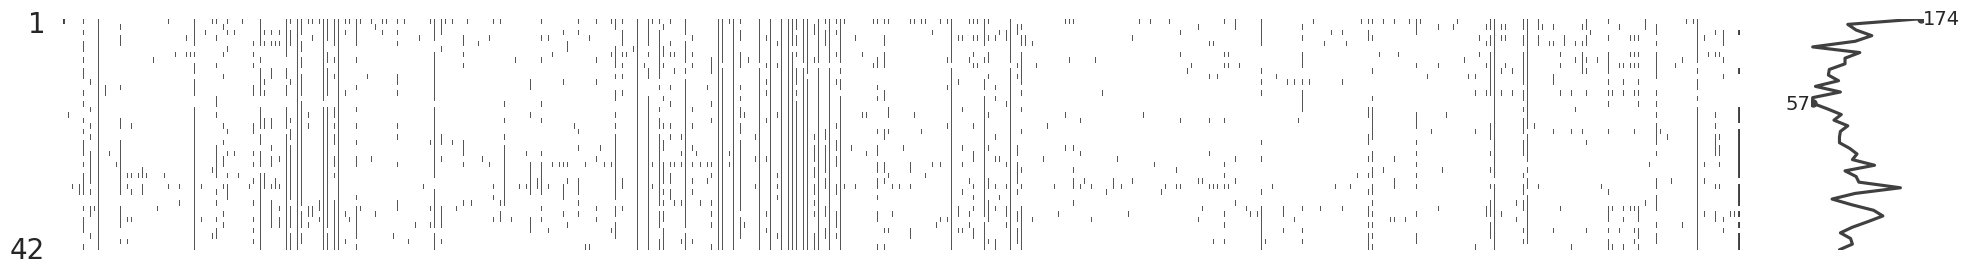

In [41]:
  #Original matrix
  import missingno as msno
  msno.matrix(table_shotgun_ok.replace(0,np.nan),figsize=(24, 3))

In [42]:
def matrix_dropout (df, por_drop ,seed):
  if por_drop <1:
    shape= df.shape[0]*df.shape[1]
    zeros= shape*por_drop
    ones=  shape*( 1-por_drop)
    random_1 = np.array([])
    random_0 = np.array([])
    zeros = round(zeros)
    ones = round(ones)
    random_0 = np.zeros(zeros)
    random_1 = np.ones(ones)

    random_dropout = np.append(random_0,random_1)
    random_dropout = np.random.RandomState(seed=seed).permutation(random_dropout) # we use a permutation
    random_dropout = random_dropout.reshape(df.shape)

    noise_data = df / random_dropout
    noise_data  = noise_data.replace([np.inf, -np.inf], np.nan)

    noise_data = noise_data.replace(np.nan, 0)
    noise_data
    return noise_data
  else:
    print('must be a porcentance a number less than 1 and more than 0')

#We corrupt data by randomly adding zeros to the shotgun matrix.

In [43]:
matrix_dropouted = matrix_dropout(table_shotgun_ok, por_drop = .8,seed=45)

<Axes: >

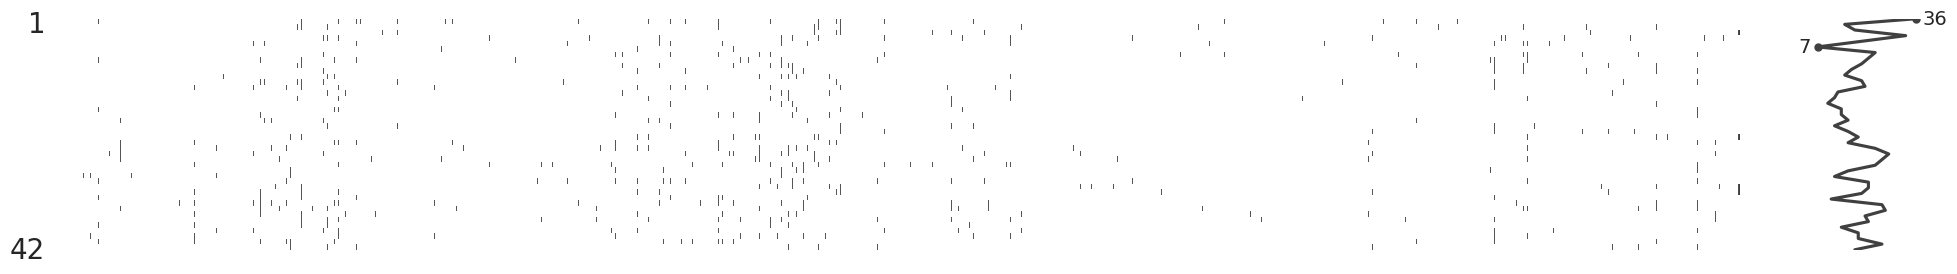

In [44]:
  #Original matrix
  import missingno as msno
  msno.matrix(matrix_dropouted.replace(0,np.nan),figsize=(24, 3))

Imputation validalitation

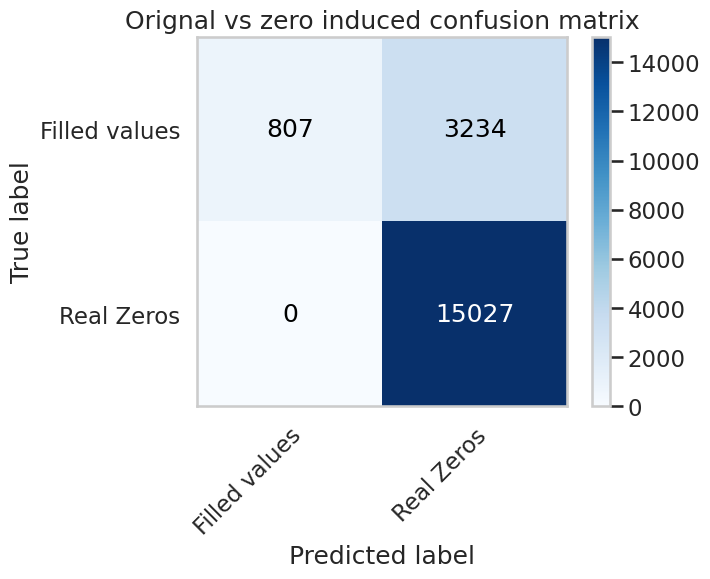

In [45]:
oririginal =  table_shotgun_ok
comparation = matrix_dropouted

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# COMPARACION ENTRE LOS VALORES CON CEROS REALES Y LA MATRIZ CON CEROS AGREGADOS
table_shotgun_ok_T_F = oririginal == 0 #los que son 0 serán True los demás será False
table_shotgun_ok_T_F= table_shotgun_ok_T_F.replace({True:1,False:0})
#table_shotgun_ok_T_F.values.flatten()
matrix_dropouted_ok_T_F = comparation == 0    #los que son 0 serán True los demás será False
matrix_dropouted_ok_T_F = matrix_dropouted_ok_T_F.replace({True:1,False:0})
#matrix_dropouted_ok_T_F.values.flatten()
true_labels = table_shotgun_ok_T_F.values.flatten()
pred_labels = matrix_dropouted_ok_T_F.values.flatten()
cm = confusion_matrix(true_labels, pred_labels)

# Define class labels
class_names = ['Filled values', 'Real Zeros']
# Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Show all ticks and label them with the respective list entries
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Set title
ax.set_title("Orignal vs zero induced confusion matrix")

# Add gridlines
ax.grid(False)

# Show plot
plt.show()

In [46]:
print("Orignal vs corrupted matrix")
precision = cm[0,0] / (cm[0,0] + cm[0,1])
print(f"Precision preserving filled values: {precision}")
precision = cm[1,1] / (cm[1,0] + cm[1,1])
print(f"Precision preserving original zeros: {precision}")
TN = cm[0, 0]
FN = cm[1, 0]
TP = cm[1, 1]
FP = cm[0, 1]
accuracy = (TP + TN) / (TP + TN + FP + FN)
print(f"Accuracy: {accuracy}")

Orignal vs corrupted matrix
Precision preserving filled values: 0.19970304380103934
Precision preserving original zeros: 1.0
Accuracy: 0.8303964757709251


In [47]:
import umap
## Imputation
umap_op = umap.UMAP(n_components=10, verbose=True,metric='euclidean',n_epochs=500,min_dist=0.1,
                    n_neighbors=30,random_state=1,target_weight=0.5)
data_umap_vis_super = umap_op.fit_transform(matrix_dropouted,labels['SampleType'].replace( {'Healthy': 0, 'UC':1}))
imputed_ALL_wo_filtration= mbPHENIX(matrix_dropouted, data_umap_vis_super, t=2,decay=500,metric='euclidean',knn=15, return_type='imputed')

UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=1, verbose=True)
Sun Jul  2 10:17:41 2023 Construct fuzzy simplicial set
Sun Jul  2 10:17:41 2023 Finding Nearest Neighbors
Sun Jul  2 10:17:41 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:17:41 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:17:42 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:17:42 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))


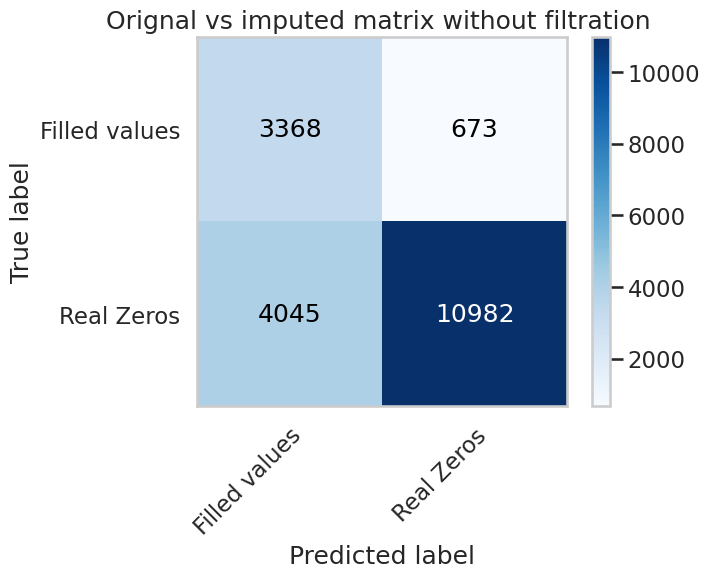

In [48]:
oririginal =  table_shotgun_ok
comparation = imputed_ALL_wo_filtration

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# COMPARACION ENTRE LOS VALORES CON CEROS REALES Y LA MATRIZ CON CEROS AGREGADOS
table_shotgun_ok_T_F = oririginal == 0 #los que son 0 serán True los demás será False
table_shotgun_ok_T_F= table_shotgun_ok_T_F.replace({True:1,False:0})
#table_shotgun_ok_T_F.values.flatten()
matrix_dropouted_ok_T_F = comparation == 0    #los que son 0 serán True los demás será False
matrix_dropouted_ok_T_F = matrix_dropouted_ok_T_F.replace({True:1,False:0})
#matrix_dropouted_ok_T_F.values.flatten()
true_labels = table_shotgun_ok_T_F.values.flatten()
pred_labels = matrix_dropouted_ok_T_F.values.flatten()
cm = confusion_matrix(true_labels, pred_labels)

# Define class labels
class_names = ['Filled values', 'Real Zeros']
# Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Show all ticks and label them with the respective list entries
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Set title
ax.set_title("Orignal vs imputed matrix without filtration ")

# Add gridlines
ax.grid(False)

# Show plot
plt.show()

In [49]:
print("Orignal vs recovered matrix without filtration")
precision = cm[0,0] / (cm[0,0] + cm[0,1])
print(f"Precision preserving filled values: {precision}")
precision = cm[1,1] / (cm[1,0] + cm[1,1])
print(f"Precision preserving original zeros: {precision}")
TN = cm[0, 0]
FN = cm[1, 0]
TP = cm[1, 1]
FP = cm[0, 1]
accuracy = (TP + TN) / (TP + TN + FP + FN)
print(f"Accuracy: {accuracy}")

Orignal vs recovered matrix without filtration
Precision preserving filled values: 0.8334570650829003
Precision preserving original zeros: 0.7308178611832036
Accuracy: 0.7525697503671072


Filtration step and not keeping ouliers

In [50]:
import umap
## Imputation
umap_op = umap.UMAP(n_components=10, verbose=True,metric='euclidean',n_epochs=500,min_dist=0.1,
                    n_neighbors=30,random_state=1,target_weight=0.5)
data_umap_vis_super = umap_op.fit_transform(matrix_dropouted,labels['SampleType'].replace( {'Healthy': 0, 'UC':1}))
imputed_ALL_wo_filtration,exp_markovian_matrix=  mbPHENIX(matrix_dropouted, data_umap_vis_super, t=2,decay=500,metric='euclidean',knn=15, return_type='both')

imp_wo_outliers = put_zeros(imputed_ALL_wo_filtration, matrix_dropouted, exp_markovian_matrix, k=20, threshold=2, keep_outliers=False)

UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=1, verbose=True)
Sun Jul  2 10:17:43 2023 Construct fuzzy simplicial set
Sun Jul  2 10:17:43 2023 Finding Nearest Neighbors
Sun Jul  2 10:17:43 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:17:43 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:17:44 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:17:44 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))


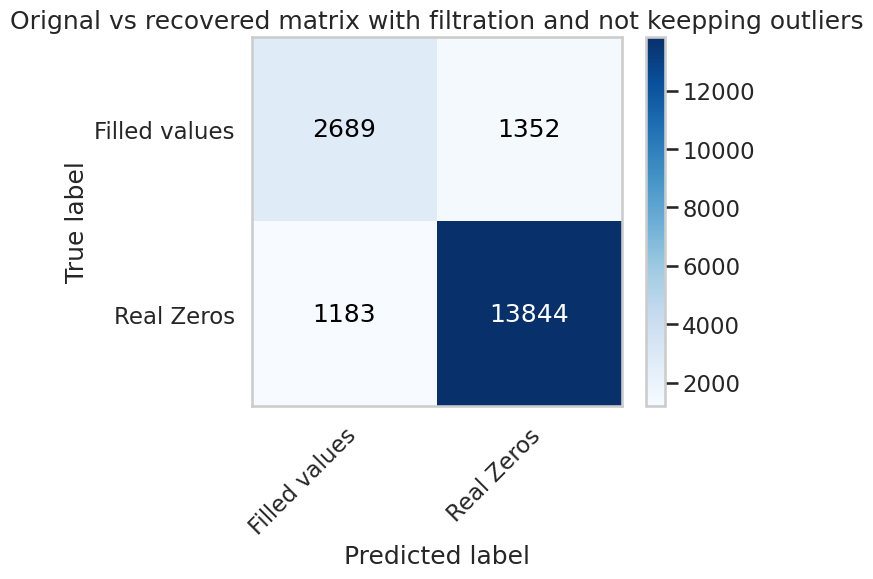

In [51]:
oririginal =  table_shotgun_ok
comparation = imp_wo_outliers

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# COMPARACION ENTRE LOS VALORES CON CEROS REALES Y LA MATRIZ CON CEROS AGREGADOS
table_shotgun_ok_T_F = oririginal == 0 #los que son 0 serán True los demás será False
table_shotgun_ok_T_F= table_shotgun_ok_T_F.replace({True:1,False:0})
#table_shotgun_ok_T_F.values.flatten()
matrix_dropouted_ok_T_F = comparation == 0    #los que son 0 serán True los demás será False
matrix_dropouted_ok_T_F = matrix_dropouted_ok_T_F.replace({True:1,False:0})
#matrix_dropouted_ok_T_F.values.flatten()
true_labels = table_shotgun_ok_T_F.values.flatten()
pred_labels = matrix_dropouted_ok_T_F.values.flatten()
cm = confusion_matrix(true_labels, pred_labels)

# Define class labels
class_names = ['Filled values', 'Real Zeros']
# Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Show all ticks and label them with the respective list entries
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Set title
ax.set_title("Orignal vs recovered matrix with filtration and not keepping outliers")

# Add gridlines
ax.grid(False)

# Show plot
plt.show()

In [52]:
print("Orignal vs recovered matrix with filtration and not keepping outliers")
precision = cm[0,0] / (cm[0,0] + cm[0,1])
print(f"Precision preserving filled values: {precision}")
precision = cm[1,1] / (cm[1,0] + cm[1,1])
print(f"Precision preserving original zeros: {precision}")
TN = cm[0, 0]
FN = cm[1, 0]
TP = cm[1, 1]
FP = cm[0, 1]
accuracy = (TP + TN) / (TP + TN + FP + FN)
print(f"Accuracy: {accuracy}")

Orignal vs recovered matrix with filtration and not keepping outliers
Precision preserving filled values: 0.6654293491709973
Precision preserving original zeros: 0.9212750382644573
Accuracy: 0.8670547514159849


In [53]:
import umap
## Imputation
umap_op = umap.UMAP(n_components=10, verbose=True,metric='euclidean',n_epochs=500,min_dist=0.1,
                    n_neighbors=30,random_state=1,target_weight=0.5)
data_umap_vis_super = umap_op.fit_transform(matrix_dropouted,labels['SampleType'].replace( {'Healthy': 0, 'UC':1}))
imputed_ALL_wo_filtration,exp_markovian_matrix=  mbPHENIX(matrix_dropouted, data_umap_vis_super, t=2,decay=500,metric='euclidean',knn=15, return_type='both')

imp_w_outliers = put_zeros(imputed_ALL_wo_filtration, matrix_dropouted, exp_markovian_matrix, k=20, threshold=2, keep_outliers=True)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=1, verbose=True)
Sun Jul  2 10:18:10 2023 Construct fuzzy simplicial set
Sun Jul  2 10:18:10 2023 Finding Nearest Neighbors
Sun Jul  2 10:18:10 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:18:10 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:18:12 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:18:12 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))


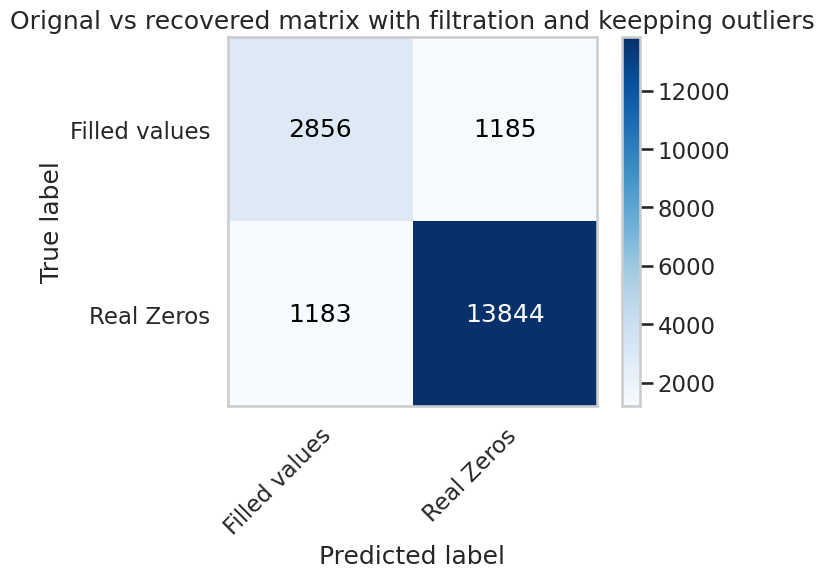

In [54]:
oririginal =  table_shotgun_ok
comparation = imp_w_outliers

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# COMPARACION ENTRE LOS VALORES CON CEROS REALES Y LA MATRIZ CON CEROS AGREGADOS
table_shotgun_ok_T_F = oririginal == 0 #los que son 0 serán True los demás será False
table_shotgun_ok_T_F= table_shotgun_ok_T_F.replace({True:1,False:0})
#table_shotgun_ok_T_F.values.flatten()
matrix_dropouted_ok_T_F = comparation == 0    #los que son 0 serán True los demás será False
matrix_dropouted_ok_T_F = matrix_dropouted_ok_T_F.replace({True:1,False:0})
#matrix_dropouted_ok_T_F.values.flatten()
true_labels = table_shotgun_ok_T_F.values.flatten()
pred_labels = matrix_dropouted_ok_T_F.values.flatten()
cm = confusion_matrix(true_labels, pred_labels)

# Define class labels
class_names = ['Filled values', 'Real Zeros']
# Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Show all ticks and label them with the respective list entries
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Set title
ax.set_title("Orignal vs recovered matrix with filtration and keepping outliers")

# Add gridlines
ax.grid(False)

# Show plot
plt.show()

In [55]:
print("Orignal vs recovered matrix with filtration and keepping outliers")
precision = cm[0,0] / (cm[0,0] + cm[0,1])
print(f"Precision preserving filled values: {precision}")
precision = cm[1,1] / (cm[1,0] + cm[1,1])
print(f"Precision preserving original zeros: {precision}")
TN = cm[0, 0]
FN = cm[1, 0]
TP = cm[1, 1]
FP = cm[0, 1]
accuracy = (TP + TN) / (TP + TN + FP + FN)
print(f"Accuracy: {accuracy}")

Orignal vs recovered matrix with filtration and keepping outliers
Precision preserving filled values: 0.7067557535263549
Precision preserving original zeros: 0.9212750382644573
Accuracy: 0.8758128802181666


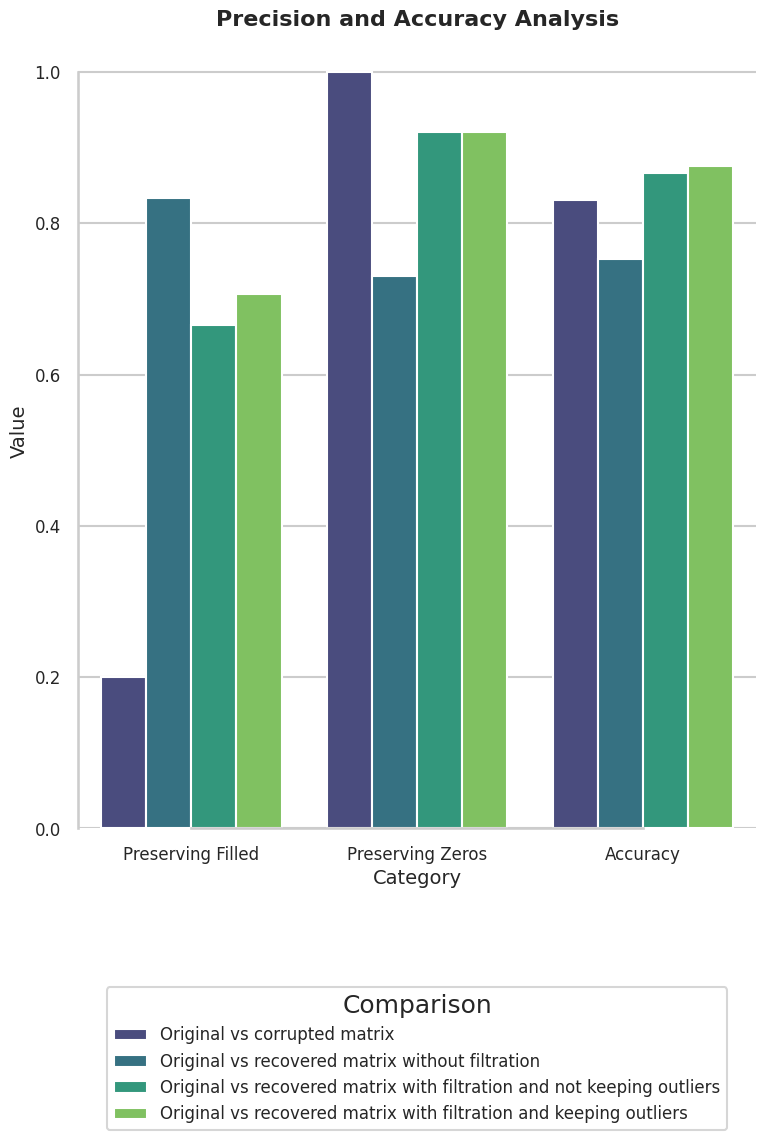

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define the data in a list of dictionaries format
data = [
    {
        'Method': 'Original vs corrupted matrix',
        'Category': 'Preserving Filled',
        'Value': 0.19970304380103934
    },
    {
        'Method': 'Original vs corrupted matrix',
        'Category': 'Preserving Zeros',
        'Value': 1.0
    },
    {
        'Method': 'Original vs corrupted matrix',
        'Category': 'Accuracy',
        'Value': 0.8303964757709251
    },
    {
        'Method': 'Original vs recovered matrix without filtration',
        'Category': 'Preserving Filled',
        'Value': 0.8334570650829003
    },
    {
        'Method': 'Original vs recovered matrix without filtration',
        'Category': 'Preserving Zeros',
        'Value': 0.7308178611832036
    },
    {
        'Method': 'Original vs recovered matrix without filtration',
        'Category': 'Accuracy',
        'Value': 0.7525697503671072
    },
    {
        'Method': 'Original vs recovered matrix with filtration and not keeping outliers',
        'Category': 'Preserving Filled',
        'Value': 0.6654293491709973
    },
    {
        'Method': 'Original vs recovered matrix with filtration and not keeping outliers',
        'Category': 'Preserving Zeros',
        'Value': 0.9212750382644573
    },
    {
        'Method': 'Original vs recovered matrix with filtration and not keeping outliers',
        'Category': 'Accuracy',
        'Value': 0.8670547514159849
    },
    {
        'Method': 'Original vs recovered matrix with filtration and keeping outliers',
        'Category': 'Preserving Filled',
        'Value': 0.7067557535263549
    },
    {
        'Method': 'Original vs recovered matrix with filtration and keeping outliers',
        'Category': 'Preserving Zeros',
        'Value': 0.9212750382644573
    },
    {
        'Method': 'Original vs recovered matrix with filtration and keeping outliers',
        'Category': 'Accuracy',
        'Value': 0.8758128802181666
    }
]

# Convert the data to a DataFrame
df = pd.DataFrame(data)

# Set the style and context to make the plot look more aesthetically pleasing
sns.set_style("whitegrid")
sns.set_context("talk")

# Create the bar plot
plt.figure(figsize=(8, 12))
barplot = sns.barplot(x='Category', y='Value', hue='Method', palette="viridis", data=df)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(bbox_to_anchor=(0.5, -0.2), loc="upper center", borderaxespad=0., fontsize=12, title='Comparison')
plt.title('Precision and Accuracy Analysis', fontsize=16, weight='bold')
plt.tight_layout()
sns.despine(trim=True)
plt.show()


Kullback-Leibler (KL) divergence

To calculate the Kullback-Leibler (KL) divergence between two probability distributions, you can use the scipy.stats.entropy function. Here's an example of how you can calculate the KL divergence between two distributions

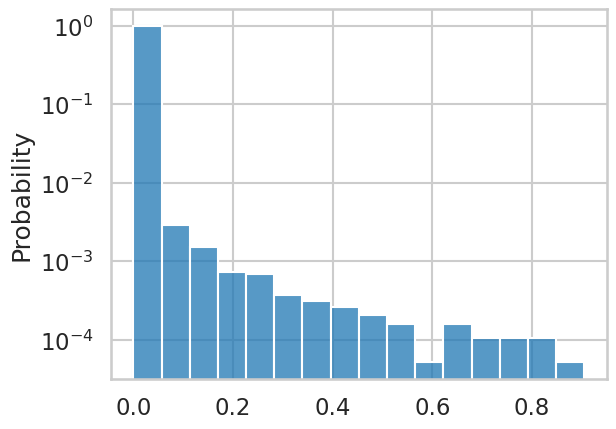

In [57]:
#### original data
data = table_shotgun_ok
#print(data)
flatten_data = data.to_numpy().flatten()
#print(max(flatten_data))
#print(min(flatten_data))

bins = np.histogram_bin_edges(flatten_data, bins='auto')
#print(bins)
hst = sns.histplot(data=flatten_data, bins=bins, stat="probability");
#hst.set_xscale("log")
hst.set_yscale("log")

Heigth_ok = [h.get_height() for h in hst.patches]
width = [h.get_x() for h in hst.patches]
#deltw = [h.get_width() for h in hst.patches]

#for w,h in zip(width,Heigth_ok):
#  print(w,h)

#density_curve = sns.kdeplot(Heigth_ok, linewidth=3)

In [58]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# calculate the kl divergence
def kl_divergence(p, q):
    return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))

# calculate the js divergence
def js_divergence(p, q):
  m = 0.5 * (p + q)
  return (0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m))

def histo(matrix_dropouted,bins):
  flatten_data_dropouted = matrix_dropouted.to_numpy().flatten()
  hst_dropouted = sns.histplot(data=flatten_data_dropouted, bins=bins, stat = "probability");
  return({h.get_height() for h in hst_dropouted.patches})

r=[]
I = []
for i in range(100):

  i=i/100
#  print(i)
  matrix_dropouted = matrix_dropout(table_shotgun_ok, por_drop = i,seed=3)
#  print(calcular_tasa_ceros(matrix_dropouted))
  flatten_data_dropouted = matrix_dropouted.to_numpy().flatten()
  hst_dropouted = sns.histplot(data=flatten_data_dropouted, bins=bins, stat = "probability");
  Heigth_dropouted = [h.get_height() for h in hst_dropouted.patches]
  #  width = [h.get_x() for h in hst_dropouted.patches]
  #deltw = [h.get_width() for h in hst.patches]
  plt.clf()

  r.append(kl_divergence(np.array(Heigth_dropouted), np.array(Heigth_ok)))

  ## Imputation
  umap_op = umap.UMAP(n_components=10, verbose=True,metric='euclidean',n_epochs=500,min_dist=0.1, n_neighbors=30,random_state=7,target_weight=0.5)
  data_umap_vis_super = umap_op.fit_transform(matrix_dropouted,labels['SampleType'].replace( {'Healthy': 0, 'UC':1}))
  # regresar t a 2, unicamente utilizar 1 si con los datos artificiales
  imputed_ALL, markov_matrix =mbPHENIX(matrix_dropouted, data_umap_vis_super, t=2,decay=600,metric='euclidean',knn=3,return_type='both')
  imputed_ALL =rescale_data(matrix_dropouted, imputed_ALL, rescale_percent=99.99)



  flatten_data_imputed = imputed_ALL.to_numpy().flatten()
  hst_imputed = sns.histplot(data=flatten_data_imputed, bins=bins, stat = "probability");
  Heigth_imputed = [h.get_height() for h in hst_imputed.patches]
  plt.clf()

  I.append(kl_divergence(np.array(Heigth_imputed), np.array(Heigth_ok)))
x1 = r
x2= I

UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:18:56 2023 Construct fuzzy simplicial set
Sun Jul  2 10:18:56 2023 Finding Nearest Neighbors
Sun Jul  2 10:18:56 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:18:56 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:18:57 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:18:57 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:18:58 2023 Construct fuzzy simplicial set
Sun Jul  2 10:18:58 2023 Finding Nearest Neighbors
Sun Jul  2 10:18:58 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:18:58 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:18:59 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:18:59 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:18:59 2023 Construct fuzzy simplicial set
Sun Jul  2 10:18:59 2023 Finding Nearest Neighbors
Sun Jul  2 10:18:59 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:18:59 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:00 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:00 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:19:00 2023 Construct fuzzy simplicial set
Sun Jul  2 10:19:00 2023 Finding Nearest Neighbors
Sun Jul  2 10:19:00 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:19:00 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:01 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:01 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:19:02 2023 Construct fuzzy simplicial set
Sun Jul  2 10:19:02 2023 Finding Nearest Neighbors
Sun Jul  2 10:19:02 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:19:02 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:03 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:03 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:19:04 2023 Construct fuzzy simplicial set
Sun Jul  2 10:19:04 2023 Finding Nearest Neighbors
Sun Jul  2 10:19:04 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:19:04 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:05 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:05 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:19:05 2023 Construct fuzzy simplicial set
Sun Jul  2 10:19:05 2023 Finding Nearest Neighbors
Sun Jul  2 10:19:05 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:19:05 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:07 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:07 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:19:07 2023 Construct fuzzy simplicial set
Sun Jul  2 10:19:07 2023 Finding Nearest Neighbors
Sun Jul  2 10:19:07 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:19:07 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:08 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:09 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:19:09 2023 Construct fuzzy simplicial set
Sun Jul  2 10:19:09 2023 Finding Nearest Neighbors
Sun Jul  2 10:19:09 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:19:09 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:10 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:10 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:19:10 2023 Construct fuzzy simplicial set
Sun Jul  2 10:19:10 2023 Finding Nearest Neighbors
Sun Jul  2 10:19:10 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:19:10 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:12 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:12 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:19:12 2023 Construct fuzzy simplicial set
Sun Jul  2 10:19:12 2023 Finding Nearest Neighbors
Sun Jul  2 10:19:12 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:19:12 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:13 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:13 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:19:14 2023 Construct fuzzy simplicial set
Sun Jul  2 10:19:14 2023 Finding Nearest Neighbors
Sun Jul  2 10:19:14 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:19:14 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:15 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:15 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:19:15 2023 Construct fuzzy simplicial set
Sun Jul  2 10:19:15 2023 Finding Nearest Neighbors
Sun Jul  2 10:19:15 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:19:15 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:16 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:16 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:19:16 2023 Construct fuzzy simplicial set
Sun Jul  2 10:19:16 2023 Finding Nearest Neighbors
Sun Jul  2 10:19:16 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:19:16 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:17 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:17 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:19:18 2023 Construct fuzzy simplicial set
Sun Jul  2 10:19:18 2023 Finding Nearest Neighbors
Sun Jul  2 10:19:18 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:19:18 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:19 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:19 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:19:19 2023 Construct fuzzy simplicial set
Sun Jul  2 10:19:19 2023 Finding Nearest Neighbors
Sun Jul  2 10:19:19 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:19:19 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:21 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:21 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:19:22 2023 Construct fuzzy simplicial set
Sun Jul  2 10:19:22 2023 Finding Nearest Neighbors
Sun Jul  2 10:19:22 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:19:22 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:23 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:23 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:19:23 2023 Construct fuzzy simplicial set
Sun Jul  2 10:19:23 2023 Finding Nearest Neighbors
Sun Jul  2 10:19:23 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:19:23 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:24 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:24 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:19:24 2023 Construct fuzzy simplicial set
Sun Jul  2 10:19:24 2023 Finding Nearest Neighbors
Sun Jul  2 10:19:24 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:19:24 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:25 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:26 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:19:26 2023 Construct fuzzy simplicial set
Sun Jul  2 10:19:26 2023 Finding Nearest Neighbors
Sun Jul  2 10:19:26 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:19:26 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:27 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:27 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:19:27 2023 Construct fuzzy simplicial set
Sun Jul  2 10:19:27 2023 Finding Nearest Neighbors
Sun Jul  2 10:19:27 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:19:27 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:28 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:28 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:19:28 2023 Construct fuzzy simplicial set
Sun Jul  2 10:19:28 2023 Finding Nearest Neighbors
Sun Jul  2 10:19:28 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:19:28 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:30 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:30 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:19:30 2023 Construct fuzzy simplicial set
Sun Jul  2 10:19:30 2023 Finding Nearest Neighbors
Sun Jul  2 10:19:30 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:19:30 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:32 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:32 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:19:32 2023 Construct fuzzy simplicial set
Sun Jul  2 10:19:32 2023 Finding Nearest Neighbors
Sun Jul  2 10:19:32 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:19:32 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:34 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:34 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:19:34 2023 Construct fuzzy simplicial set
Sun Jul  2 10:19:34 2023 Finding Nearest Neighbors
Sun Jul  2 10:19:34 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:19:34 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:35 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:35 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:19:35 2023 Construct fuzzy simplicial set
Sun Jul  2 10:19:35 2023 Finding Nearest Neighbors
Sun Jul  2 10:19:35 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:19:35 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:36 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:37 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:19:37 2023 Construct fuzzy simplicial set
Sun Jul  2 10:19:37 2023 Finding Nearest Neighbors
Sun Jul  2 10:19:37 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:19:37 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:38 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:38 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:19:38 2023 Construct fuzzy simplicial set
Sun Jul  2 10:19:38 2023 Finding Nearest Neighbors
Sun Jul  2 10:19:38 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:19:38 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:40 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:40 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:19:40 2023 Construct fuzzy simplicial set
Sun Jul  2 10:19:40 2023 Finding Nearest Neighbors
Sun Jul  2 10:19:40 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:19:40 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:41 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:41 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:19:42 2023 Construct fuzzy simplicial set
Sun Jul  2 10:19:42 2023 Finding Nearest Neighbors
Sun Jul  2 10:19:42 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:19:42 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:43 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:43 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:19:43 2023 Construct fuzzy simplicial set
Sun Jul  2 10:19:43 2023 Finding Nearest Neighbors
Sun Jul  2 10:19:43 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:19:43 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:44 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:44 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:19:44 2023 Construct fuzzy simplicial set
Sun Jul  2 10:19:44 2023 Finding Nearest Neighbors
Sun Jul  2 10:19:44 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:19:44 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:46 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:46 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:19:46 2023 Construct fuzzy simplicial set
Sun Jul  2 10:19:46 2023 Finding Nearest Neighbors
Sun Jul  2 10:19:46 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:19:46 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:48 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:48 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:19:48 2023 Construct fuzzy simplicial set
Sun Jul  2 10:19:48 2023 Finding Nearest Neighbors
Sun Jul  2 10:19:48 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:19:48 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:50 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:50 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:19:50 2023 Construct fuzzy simplicial set
Sun Jul  2 10:19:50 2023 Finding Nearest Neighbors
Sun Jul  2 10:19:50 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:19:50 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:51 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:51 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:19:51 2023 Construct fuzzy simplicial set
Sun Jul  2 10:19:51 2023 Finding Nearest Neighbors
Sun Jul  2 10:19:51 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:19:51 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:52 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:52 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:19:53 2023 Construct fuzzy simplicial set
Sun Jul  2 10:19:53 2023 Finding Nearest Neighbors
Sun Jul  2 10:19:53 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:19:53 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:54 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:54 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:19:54 2023 Construct fuzzy simplicial set
Sun Jul  2 10:19:54 2023 Finding Nearest Neighbors
Sun Jul  2 10:19:54 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:19:54 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:55 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:55 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:19:55 2023 Construct fuzzy simplicial set
Sun Jul  2 10:19:55 2023 Finding Nearest Neighbors
Sun Jul  2 10:19:55 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:19:55 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:57 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:57 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:19:58 2023 Construct fuzzy simplicial set
Sun Jul  2 10:19:58 2023 Finding Nearest Neighbors
Sun Jul  2 10:19:58 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:19:58 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:19:59 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:19:59 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:20:00 2023 Construct fuzzy simplicial set
Sun Jul  2 10:20:00 2023 Finding Nearest Neighbors
Sun Jul  2 10:20:00 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:20:00 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:20:01 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:20:01 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:20:01 2023 Construct fuzzy simplicial set
Sun Jul  2 10:20:01 2023 Finding Nearest Neighbors
Sun Jul  2 10:20:01 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:20:01 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:20:02 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:20:02 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:20:03 2023 Construct fuzzy simplicial set
Sun Jul  2 10:20:03 2023 Finding Nearest Neighbors
Sun Jul  2 10:20:03 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:20:03 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:20:05 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:20:05 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:20:05 2023 Construct fuzzy simplicial set
Sun Jul  2 10:20:05 2023 Finding Nearest Neighbors
Sun Jul  2 10:20:05 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:20:05 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:20:06 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:20:06 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:20:06 2023 Construct fuzzy simplicial set
Sun Jul  2 10:20:06 2023 Finding Nearest Neighbors
Sun Jul  2 10:20:06 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:20:06 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:20:07 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:20:07 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:20:08 2023 Construct fuzzy simplicial set
Sun Jul  2 10:20:08 2023 Finding Nearest Neighbors
Sun Jul  2 10:20:08 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:20:08 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:20:09 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:20:09 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:20:10 2023 Construct fuzzy simplicial set
Sun Jul  2 10:20:10 2023 Finding Nearest Neighbors
Sun Jul  2 10:20:10 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:20:10 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:20:11 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:20:11 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:20:12 2023 Construct fuzzy simplicial set
Sun Jul  2 10:20:12 2023 Finding Nearest Neighbors
Sun Jul  2 10:20:12 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:20:12 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:20:14 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:20:14 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:20:15 2023 Construct fuzzy simplicial set
Sun Jul  2 10:20:15 2023 Finding Nearest Neighbors
Sun Jul  2 10:20:15 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:20:15 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:20:16 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:20:16 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:20:17 2023 Construct fuzzy simplicial set
Sun Jul  2 10:20:17 2023 Finding Nearest Neighbors
Sun Jul  2 10:20:17 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:20:17 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:20:18 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:20:18 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:20:18 2023 Construct fuzzy simplicial set
Sun Jul  2 10:20:18 2023 Finding Nearest Neighbors
Sun Jul  2 10:20:18 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:20:18 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:20:20 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:20:20 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:20:20 2023 Construct fuzzy simplicial set
Sun Jul  2 10:20:20 2023 Finding Nearest Neighbors
Sun Jul  2 10:20:20 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:20:20 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:20:21 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:20:21 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:20:22 2023 Construct fuzzy simplicial set
Sun Jul  2 10:20:22 2023 Finding Nearest Neighbors
Sun Jul  2 10:20:22 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:20:22 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:20:23 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:20:23 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:20:23 2023 Construct fuzzy simplicial set
Sun Jul  2 10:20:23 2023 Finding Nearest Neighbors
Sun Jul  2 10:20:23 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:20:23 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:20:25 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:20:25 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:20:25 2023 Construct fuzzy simplicial set
Sun Jul  2 10:20:25 2023 Finding Nearest Neighbors
Sun Jul  2 10:20:25 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:20:25 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:20:27 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:20:27 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:20:27 2023 Construct fuzzy simplicial set
Sun Jul  2 10:20:27 2023 Finding Nearest Neighbors
Sun Jul  2 10:20:27 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:20:27 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:20:28 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:20:28 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:20:28 2023 Construct fuzzy simplicial set
Sun Jul  2 10:20:28 2023 Finding Nearest Neighbors
Sun Jul  2 10:20:28 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:20:28 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:20:30 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:20:30 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:20:30 2023 Construct fuzzy simplicial set
Sun Jul  2 10:20:30 2023 Finding Nearest Neighbors
Sun Jul  2 10:20:30 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:20:30 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:20:31 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:20:31 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:20:32 2023 Construct fuzzy simplicial set
Sun Jul  2 10:20:32 2023 Finding Nearest Neighbors
Sun Jul  2 10:20:32 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:20:32 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:20:33 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:20:33 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:20:33 2023 Construct fuzzy simplicial set
Sun Jul  2 10:20:33 2023 Finding Nearest Neighbors
Sun Jul  2 10:20:33 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:20:33 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:20:34 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:20:34 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:20:35 2023 Construct fuzzy simplicial set
Sun Jul  2 10:20:35 2023 Finding Nearest Neighbors
Sun Jul  2 10:20:35 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:20:35 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:20:36 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:20:36 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:20:36 2023 Construct fuzzy simplicial set
Sun Jul  2 10:20:36 2023 Finding Nearest Neighbors
Sun Jul  2 10:20:36 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:20:36 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:20:38 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:20:38 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:20:38 2023 Construct fuzzy simplicial set
Sun Jul  2 10:20:38 2023 Finding Nearest Neighbors
Sun Jul  2 10:20:38 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:20:38 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:20:40 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:20:40 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:20:41 2023 Construct fuzzy simplicial set
Sun Jul  2 10:20:41 2023 Finding Nearest Neighbors
Sun Jul  2 10:20:41 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:20:41 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:20:42 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:20:42 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:20:42 2023 Construct fuzzy simplicial set
Sun Jul  2 10:20:42 2023 Finding Nearest Neighbors
Sun Jul  2 10:20:42 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:20:42 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:20:43 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:20:43 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:20:43 2023 Construct fuzzy simplicial set
Sun Jul  2 10:20:43 2023 Finding Nearest Neighbors
Sun Jul  2 10:20:43 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:20:43 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:20:45 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:20:45 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:20:45 2023 Construct fuzzy simplicial set
Sun Jul  2 10:20:45 2023 Finding Nearest Neighbors
Sun Jul  2 10:20:45 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:20:45 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:20:46 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:20:46 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:20:46 2023 Construct fuzzy simplicial set
Sun Jul  2 10:20:46 2023 Finding Nearest Neighbors
Sun Jul  2 10:20:46 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:20:46 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:20:47 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:20:47 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:20:48 2023 Construct fuzzy simplicial set
Sun Jul  2 10:20:48 2023 Finding Nearest Neighbors
Sun Jul  2 10:20:48 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:20:48 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:20:50 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:20:50 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:20:50 2023 Construct fuzzy simplicial set
Sun Jul  2 10:20:50 2023 Finding Nearest Neighbors
Sun Jul  2 10:20:50 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:20:50 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:20:52 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:20:52 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:20:52 2023 Construct fuzzy simplicial set
Sun Jul  2 10:20:52 2023 Finding Nearest Neighbors
Sun Jul  2 10:20:52 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:20:52 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:20:53 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:20:53 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:20:54 2023 Construct fuzzy simplicial set
Sun Jul  2 10:20:54 2023 Finding Nearest Neighbors
Sun Jul  2 10:20:54 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:20:54 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:20:55 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:20:55 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:20:55 2023 Construct fuzzy simplicial set
Sun Jul  2 10:20:55 2023 Finding Nearest Neighbors
Sun Jul  2 10:20:55 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:20:55 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:20:56 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:20:56 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:20:57 2023 Construct fuzzy simplicial set
Sun Jul  2 10:20:57 2023 Finding Nearest Neighbors
Sun Jul  2 10:20:57 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:20:57 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:20:58 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:20:58 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:20:58 2023 Construct fuzzy simplicial set
Sun Jul  2 10:20:58 2023 Finding Nearest Neighbors
Sun Jul  2 10:20:58 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:20:58 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:21:00 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:21:00 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:21:00 2023 Construct fuzzy simplicial set
Sun Jul  2 10:21:00 2023 Finding Nearest Neighbors
Sun Jul  2 10:21:00 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:21:00 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:21:01 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:21:01 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:21:02 2023 Construct fuzzy simplicial set
Sun Jul  2 10:21:02 2023 Finding Nearest Neighbors
Sun Jul  2 10:21:02 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:21:02 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:21:03 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:21:03 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:21:04 2023 Construct fuzzy simplicial set
Sun Jul  2 10:21:04 2023 Finding Nearest Neighbors
Sun Jul  2 10:21:04 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:21:04 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:21:05 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:21:05 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:21:06 2023 Construct fuzzy simplicial set
Sun Jul  2 10:21:06 2023 Finding Nearest Neighbors
Sun Jul  2 10:21:06 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:21:06 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:21:07 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:21:07 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:21:07 2023 Construct fuzzy simplicial set
Sun Jul  2 10:21:07 2023 Finding Nearest Neighbors
Sun Jul  2 10:21:07 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:21:07 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:21:08 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:21:08 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:21:09 2023 Construct fuzzy simplicial set
Sun Jul  2 10:21:09 2023 Finding Nearest Neighbors
Sun Jul  2 10:21:09 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:21:09 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:21:11 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:21:11 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:21:11 2023 Construct fuzzy simplicial set
Sun Jul  2 10:21:11 2023 Finding Nearest Neighbors
Sun Jul  2 10:21:11 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:21:11 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:21:12 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:21:12 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:21:12 2023 Construct fuzzy simplicial set
Sun Jul  2 10:21:12 2023 Finding Nearest Neighbors
Sun Jul  2 10:21:12 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:21:12 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:21:14 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:21:14 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:21:14 2023 Construct fuzzy simplicial set
Sun Jul  2 10:21:14 2023 Finding Nearest Neighbors
Sun Jul  2 10:21:14 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:21:14 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:21:15 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:21:15 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:21:15 2023 Construct fuzzy simplicial set
Sun Jul  2 10:21:15 2023 Finding Nearest Neighbors
Sun Jul  2 10:21:15 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:21:15 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:21:17 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:21:17 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:21:17 2023 Construct fuzzy simplicial set
Sun Jul  2 10:21:17 2023 Finding Nearest Neighbors
Sun Jul  2 10:21:17 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:21:17 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:21:19 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:21:19 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:21:19 2023 Construct fuzzy simplicial set
Sun Jul  2 10:21:19 2023 Finding Nearest Neighbors
Sun Jul  2 10:21:19 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:21:19 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:21:21 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:21:21 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:21:21 2023 Construct fuzzy simplicial set
Sun Jul  2 10:21:21 2023 Finding Nearest Neighbors
Sun Jul  2 10:21:21 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:21:21 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:21:23 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:21:23 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:21:23 2023 Construct fuzzy simplicial set
Sun Jul  2 10:21:23 2023 Finding Nearest Neighbors
Sun Jul  2 10:21:23 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:21:23 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:21:24 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:21:24 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:21:24 2023 Construct fuzzy simplicial set
Sun Jul  2 10:21:24 2023 Finding Nearest Neighbors
Sun Jul  2 10:21:24 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:21:24 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:21:26 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:21:26 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:21:26 2023 Construct fuzzy simplicial set
Sun Jul  2 10:21:26 2023 Finding Nearest Neighbors
Sun Jul  2 10:21:26 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:21:26 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:21:27 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:21:27 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:21:27 2023 Construct fuzzy simplicial set
Sun Jul  2 10:21:27 2023 Finding Nearest Neighbors
Sun Jul  2 10:21:27 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:21:27 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:21:29 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:21:29 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:21:29 2023 Construct fuzzy simplicial set
Sun Jul  2 10:21:29 2023 Finding Nearest Neighbors
Sun Jul  2 10:21:29 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:21:29 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:21:30 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:21:31 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:21:32 2023 Construct fuzzy simplicial set
Sun Jul  2 10:21:32 2023 Finding Nearest Neighbors
Sun Jul  2 10:21:32 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:21:32 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:21:33 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:21:33 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:21:33 2023 Construct fuzzy simplicial set
Sun Jul  2 10:21:33 2023 Finding Nearest Neighbors
Sun Jul  2 10:21:33 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:21:33 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:21:34 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:21:35 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:21:35 2023 Construct fuzzy simplicial set
Sun Jul  2 10:21:35 2023 Finding Nearest Neighbors
Sun Jul  2 10:21:35 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:21:35 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:21:36 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:21:36 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:21:36 2023 Construct fuzzy simplicial set
Sun Jul  2 10:21:36 2023 Finding Nearest Neighbors
Sun Jul  2 10:21:36 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:21:36 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:21:38 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:21:38 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:21:38 2023 Construct fuzzy simplicial set
Sun Jul  2 10:21:38 2023 Finding Nearest Neighbors
Sun Jul  2 10:21:38 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:21:38 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:21:39 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:21:39 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:21:39 2023 Construct fuzzy simplicial set
Sun Jul  2 10:21:39 2023 Finding Nearest Neighbors
Sun Jul  2 10:21:39 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:21:39 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:21:41 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:21:41 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:21:42 2023 Construct fuzzy simplicial set
Sun Jul  2 10:21:42 2023 Finding Nearest Neighbors
Sun Jul  2 10:21:42 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:21:42 2023 Construct embedding


<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:21:43 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:21:43 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-58-949373af1569>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-58-949373af1569>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


<Figure size 640x480 with 0 Axes>

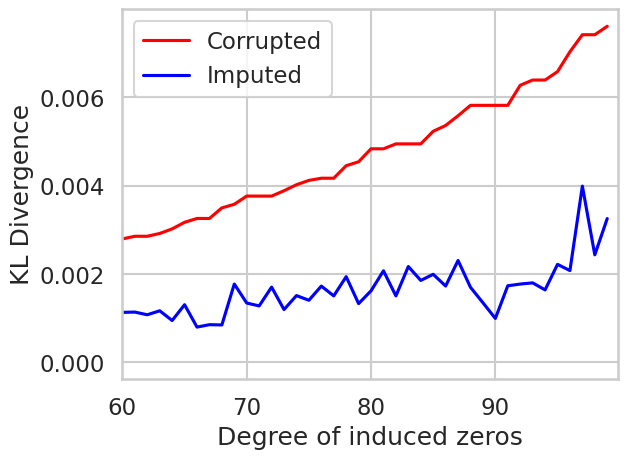

In [59]:
plt.plot (np.linspace(0,99,100),x1, label = 'Corrupted', color = 'red')
plt.plot (np.linspace(0,99,100),x2, label = 'Imputed', color = 'blue')

plt.ylabel('KL Divergence')
plt.xlabel('Degree of induced zeros')
plt.legend()
# Rango específico del eje x (por ejemplo, de 20 a 50)
plt.xlim(60, 99.9)

plt.show()

In [60]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# calculate the kl divergence
def kl_divergence(p, q):
    return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))

# calculate the js divergence
def js_divergence(p, q):
  m = 0.5 * (p + q)
  return (0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m))

def histo(matrix_dropouted,bins):
  flatten_data_dropouted = matrix_dropouted.to_numpy().flatten()
  hst_dropouted = sns.histplot(data=flatten_data_dropouted, bins=bins, stat = "probability");
  return({h.get_height() for h in hst_dropouted.patches})

r=[]
I = []
for i in range(100):

  i=i/100
#  print(i)
  matrix_dropouted = matrix_dropout(table_shotgun_ok, por_drop = i,seed=3)
#  print(calcular_tasa_ceros(matrix_dropouted))
  flatten_data_dropouted = matrix_dropouted.to_numpy().flatten()
  hst_dropouted = sns.histplot(data=flatten_data_dropouted, bins=bins, stat = "probability");
  Heigth_dropouted = [h.get_height() for h in hst_dropouted.patches]
  #  width = [h.get_x() for h in hst_dropouted.patches]
  #deltw = [h.get_width() for h in hst.patches]
  plt.clf()

  r.append(kl_divergence(np.array(Heigth_dropouted), np.array(Heigth_ok)))

  ## Imputation
  umap_op = umap.UMAP(n_components=10, verbose=True,metric='euclidean',n_epochs=500,min_dist=0.1, n_neighbors=30,random_state=7,target_weight=0.5)
  data_umap_vis_super = umap_op.fit_transform(matrix_dropouted,labels['SampleType'].replace( {'Healthy': 0, 'UC':1}))
  # regresar t a 2, unicamente utilizar 1 si con los datos artificiales
  imputed_ALL, markov_matrix =mbPHENIX(matrix_dropouted, data_umap_vis_super, t=2,decay=600,metric='euclidean',knn=3,return_type='both')
  imputed_ALL =rescale_data(matrix_dropouted, imputed_ALL, rescale_percent=99.99)
  imputed_ALL = put_zeros(imputed_ALL, matrix_dropouted, markov_matrix, k=20, threshold=2, keep_outliers=False)



  flatten_data_imputed = imputed_ALL.to_numpy().flatten()
  hst_imputed = sns.histplot(data=flatten_data_imputed, bins=bins, stat = "probability");
  Heigth_imputed = [h.get_height() for h in hst_imputed.patches]
  plt.clf()

  I.append(kl_divergence(np.array(Heigth_imputed), np.array(Heigth_ok)))
y1 = r
y2= I

UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:21:44 2023 Construct fuzzy simplicial set
Sun Jul  2 10:21:44 2023 Finding Nearest Neighbors
Sun Jul  2 10:21:44 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:21:44 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:21:46 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:21:46 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:21:55 2023 Construct fuzzy simplicial set
Sun Jul  2 10:21:55 2023 Finding Nearest Neighbors
Sun Jul  2 10:21:55 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:21:55 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:21:56 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:21:56 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:22:06 2023 Construct fuzzy simplicial set
Sun Jul  2 10:22:06 2023 Finding Nearest Neighbors
Sun Jul  2 10:22:06 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:22:06 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:22:07 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:22:07 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:22:17 2023 Construct fuzzy simplicial set
Sun Jul  2 10:22:17 2023 Finding Nearest Neighbors
Sun Jul  2 10:22:17 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:22:17 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:22:18 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:22:18 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:22:28 2023 Construct fuzzy simplicial set
Sun Jul  2 10:22:28 2023 Finding Nearest Neighbors
Sun Jul  2 10:22:28 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:22:28 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:22:30 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:22:30 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:22:40 2023 Construct fuzzy simplicial set
Sun Jul  2 10:22:40 2023 Finding Nearest Neighbors
Sun Jul  2 10:22:40 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:22:40 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:22:41 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:22:41 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:22:50 2023 Construct fuzzy simplicial set
Sun Jul  2 10:22:50 2023 Finding Nearest Neighbors
Sun Jul  2 10:22:50 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:22:50 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:22:52 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:22:52 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:23:01 2023 Construct fuzzy simplicial set
Sun Jul  2 10:23:01 2023 Finding Nearest Neighbors
Sun Jul  2 10:23:01 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:23:01 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:23:02 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:23:02 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:23:12 2023 Construct fuzzy simplicial set
Sun Jul  2 10:23:12 2023 Finding Nearest Neighbors
Sun Jul  2 10:23:12 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:23:12 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:23:13 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:23:13 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:23:22 2023 Construct fuzzy simplicial set
Sun Jul  2 10:23:22 2023 Finding Nearest Neighbors
Sun Jul  2 10:23:22 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:23:22 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:23:23 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:23:23 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:23:33 2023 Construct fuzzy simplicial set
Sun Jul  2 10:23:33 2023 Finding Nearest Neighbors
Sun Jul  2 10:23:33 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:23:33 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:23:35 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:23:35 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:23:45 2023 Construct fuzzy simplicial set
Sun Jul  2 10:23:45 2023 Finding Nearest Neighbors
Sun Jul  2 10:23:45 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:23:45 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:23:46 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:23:46 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:23:56 2023 Construct fuzzy simplicial set
Sun Jul  2 10:23:56 2023 Finding Nearest Neighbors
Sun Jul  2 10:23:56 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:23:56 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:23:57 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:23:57 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:24:07 2023 Construct fuzzy simplicial set
Sun Jul  2 10:24:07 2023 Finding Nearest Neighbors
Sun Jul  2 10:24:07 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:24:07 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:24:08 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:24:08 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:24:18 2023 Construct fuzzy simplicial set
Sun Jul  2 10:24:18 2023 Finding Nearest Neighbors
Sun Jul  2 10:24:18 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:24:18 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:24:19 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:24:19 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:24:29 2023 Construct fuzzy simplicial set
Sun Jul  2 10:24:29 2023 Finding Nearest Neighbors
Sun Jul  2 10:24:29 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:24:29 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:24:30 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:24:30 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:24:39 2023 Construct fuzzy simplicial set
Sun Jul  2 10:24:39 2023 Finding Nearest Neighbors
Sun Jul  2 10:24:39 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:24:39 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:24:41 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:24:41 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:24:51 2023 Construct fuzzy simplicial set
Sun Jul  2 10:24:51 2023 Finding Nearest Neighbors
Sun Jul  2 10:24:51 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:24:51 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:24:52 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:24:52 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:25:02 2023 Construct fuzzy simplicial set
Sun Jul  2 10:25:02 2023 Finding Nearest Neighbors
Sun Jul  2 10:25:02 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:25:02 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:25:03 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:25:03 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:25:13 2023 Construct fuzzy simplicial set
Sun Jul  2 10:25:13 2023 Finding Nearest Neighbors
Sun Jul  2 10:25:13 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:25:13 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:25:14 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:25:14 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:25:23 2023 Construct fuzzy simplicial set
Sun Jul  2 10:25:23 2023 Finding Nearest Neighbors
Sun Jul  2 10:25:23 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:25:23 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:25:24 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:25:24 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:25:34 2023 Construct fuzzy simplicial set
Sun Jul  2 10:25:34 2023 Finding Nearest Neighbors
Sun Jul  2 10:25:34 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:25:34 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:25:35 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:25:35 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:25:45 2023 Construct fuzzy simplicial set
Sun Jul  2 10:25:45 2023 Finding Nearest Neighbors
Sun Jul  2 10:25:45 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:25:45 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:25:47 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:25:47 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:25:57 2023 Construct fuzzy simplicial set
Sun Jul  2 10:25:57 2023 Finding Nearest Neighbors
Sun Jul  2 10:25:57 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:25:57 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:25:59 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:25:59 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:26:09 2023 Construct fuzzy simplicial set
Sun Jul  2 10:26:09 2023 Finding Nearest Neighbors
Sun Jul  2 10:26:09 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:26:09 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:26:10 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:26:10 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:26:20 2023 Construct fuzzy simplicial set
Sun Jul  2 10:26:20 2023 Finding Nearest Neighbors
Sun Jul  2 10:26:20 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:26:20 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:26:21 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:26:21 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:26:31 2023 Construct fuzzy simplicial set
Sun Jul  2 10:26:31 2023 Finding Nearest Neighbors
Sun Jul  2 10:26:31 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:26:31 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:26:32 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:26:32 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:26:43 2023 Construct fuzzy simplicial set
Sun Jul  2 10:26:43 2023 Finding Nearest Neighbors
Sun Jul  2 10:26:43 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:26:43 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:26:44 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:26:44 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:26:54 2023 Construct fuzzy simplicial set
Sun Jul  2 10:26:54 2023 Finding Nearest Neighbors
Sun Jul  2 10:26:54 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:26:54 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:26:56 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:26:56 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:27:05 2023 Construct fuzzy simplicial set
Sun Jul  2 10:27:05 2023 Finding Nearest Neighbors
Sun Jul  2 10:27:05 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:27:05 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:27:06 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:27:06 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:27:16 2023 Construct fuzzy simplicial set
Sun Jul  2 10:27:16 2023 Finding Nearest Neighbors
Sun Jul  2 10:27:16 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:27:16 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:27:17 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:27:17 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:27:28 2023 Construct fuzzy simplicial set
Sun Jul  2 10:27:28 2023 Finding Nearest Neighbors
Sun Jul  2 10:27:28 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:27:28 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:27:29 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:27:29 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:27:39 2023 Construct fuzzy simplicial set
Sun Jul  2 10:27:39 2023 Finding Nearest Neighbors
Sun Jul  2 10:27:39 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:27:39 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:27:40 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:27:40 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:27:50 2023 Construct fuzzy simplicial set
Sun Jul  2 10:27:50 2023 Finding Nearest Neighbors
Sun Jul  2 10:27:50 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:27:50 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:27:52 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:27:52 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:28:03 2023 Construct fuzzy simplicial set
Sun Jul  2 10:28:03 2023 Finding Nearest Neighbors
Sun Jul  2 10:28:03 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:28:03 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:28:05 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:28:05 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:28:15 2023 Construct fuzzy simplicial set
Sun Jul  2 10:28:15 2023 Finding Nearest Neighbors
Sun Jul  2 10:28:15 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:28:15 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:28:16 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:28:16 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:28:26 2023 Construct fuzzy simplicial set
Sun Jul  2 10:28:26 2023 Finding Nearest Neighbors
Sun Jul  2 10:28:26 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:28:26 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:28:28 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:28:28 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:28:38 2023 Construct fuzzy simplicial set
Sun Jul  2 10:28:38 2023 Finding Nearest Neighbors
Sun Jul  2 10:28:38 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:28:38 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:28:39 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:28:39 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:28:49 2023 Construct fuzzy simplicial set
Sun Jul  2 10:28:49 2023 Finding Nearest Neighbors
Sun Jul  2 10:28:49 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:28:49 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:28:50 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:28:50 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:29:00 2023 Construct fuzzy simplicial set
Sun Jul  2 10:29:00 2023 Finding Nearest Neighbors
Sun Jul  2 10:29:00 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:29:00 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:29:01 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:29:01 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:29:11 2023 Construct fuzzy simplicial set
Sun Jul  2 10:29:11 2023 Finding Nearest Neighbors
Sun Jul  2 10:29:11 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:29:11 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:29:13 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:29:13 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:29:23 2023 Construct fuzzy simplicial set
Sun Jul  2 10:29:23 2023 Finding Nearest Neighbors
Sun Jul  2 10:29:23 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:29:23 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:29:24 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:29:24 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:29:34 2023 Construct fuzzy simplicial set
Sun Jul  2 10:29:34 2023 Finding Nearest Neighbors
Sun Jul  2 10:29:34 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:29:34 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:29:35 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:29:35 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:29:45 2023 Construct fuzzy simplicial set
Sun Jul  2 10:29:45 2023 Finding Nearest Neighbors
Sun Jul  2 10:29:45 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:29:45 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:29:46 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:29:46 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:29:56 2023 Construct fuzzy simplicial set
Sun Jul  2 10:29:56 2023 Finding Nearest Neighbors
Sun Jul  2 10:29:56 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:29:56 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:29:57 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:29:57 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:30:07 2023 Construct fuzzy simplicial set
Sun Jul  2 10:30:07 2023 Finding Nearest Neighbors
Sun Jul  2 10:30:07 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:30:07 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:30:08 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:30:08 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:30:18 2023 Construct fuzzy simplicial set
Sun Jul  2 10:30:18 2023 Finding Nearest Neighbors
Sun Jul  2 10:30:18 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:30:18 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:30:20 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:30:20 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:30:29 2023 Construct fuzzy simplicial set
Sun Jul  2 10:30:29 2023 Finding Nearest Neighbors
Sun Jul  2 10:30:29 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:30:29 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:30:31 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:30:31 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:30:40 2023 Construct fuzzy simplicial set
Sun Jul  2 10:30:40 2023 Finding Nearest Neighbors
Sun Jul  2 10:30:40 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:30:40 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:30:42 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:30:42 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:30:51 2023 Construct fuzzy simplicial set
Sun Jul  2 10:30:51 2023 Finding Nearest Neighbors
Sun Jul  2 10:30:51 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:30:51 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:30:52 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:30:52 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:31:02 2023 Construct fuzzy simplicial set
Sun Jul  2 10:31:02 2023 Finding Nearest Neighbors
Sun Jul  2 10:31:02 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:31:02 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:31:03 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:31:03 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:31:13 2023 Construct fuzzy simplicial set
Sun Jul  2 10:31:13 2023 Finding Nearest Neighbors
Sun Jul  2 10:31:13 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:31:13 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:31:15 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:31:15 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:31:24 2023 Construct fuzzy simplicial set
Sun Jul  2 10:31:24 2023 Finding Nearest Neighbors
Sun Jul  2 10:31:24 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:31:24 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:31:26 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:31:26 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:31:36 2023 Construct fuzzy simplicial set
Sun Jul  2 10:31:36 2023 Finding Nearest Neighbors
Sun Jul  2 10:31:36 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:31:36 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:31:37 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:31:37 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:31:47 2023 Construct fuzzy simplicial set
Sun Jul  2 10:31:47 2023 Finding Nearest Neighbors
Sun Jul  2 10:31:47 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:31:47 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:31:48 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:31:48 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:31:58 2023 Construct fuzzy simplicial set
Sun Jul  2 10:31:58 2023 Finding Nearest Neighbors
Sun Jul  2 10:31:58 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:31:58 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:31:59 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:31:59 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:32:09 2023 Construct fuzzy simplicial set
Sun Jul  2 10:32:09 2023 Finding Nearest Neighbors
Sun Jul  2 10:32:09 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:32:09 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:32:10 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:32:10 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:32:20 2023 Construct fuzzy simplicial set
Sun Jul  2 10:32:20 2023 Finding Nearest Neighbors
Sun Jul  2 10:32:20 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:32:20 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:32:21 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:32:21 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:32:31 2023 Construct fuzzy simplicial set
Sun Jul  2 10:32:31 2023 Finding Nearest Neighbors
Sun Jul  2 10:32:31 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:32:31 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:32:32 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:32:32 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:32:43 2023 Construct fuzzy simplicial set
Sun Jul  2 10:32:43 2023 Finding Nearest Neighbors
Sun Jul  2 10:32:43 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:32:43 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:32:44 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:32:44 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:32:54 2023 Construct fuzzy simplicial set
Sun Jul  2 10:32:54 2023 Finding Nearest Neighbors
Sun Jul  2 10:32:54 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:32:54 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:32:55 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:32:55 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:33:05 2023 Construct fuzzy simplicial set
Sun Jul  2 10:33:05 2023 Finding Nearest Neighbors
Sun Jul  2 10:33:05 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:33:05 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:33:06 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:33:06 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:33:16 2023 Construct fuzzy simplicial set
Sun Jul  2 10:33:16 2023 Finding Nearest Neighbors
Sun Jul  2 10:33:16 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:33:16 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:33:17 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:33:17 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:33:27 2023 Construct fuzzy simplicial set
Sun Jul  2 10:33:27 2023 Finding Nearest Neighbors
Sun Jul  2 10:33:27 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:33:27 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:33:28 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:33:28 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:33:38 2023 Construct fuzzy simplicial set
Sun Jul  2 10:33:38 2023 Finding Nearest Neighbors
Sun Jul  2 10:33:38 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:33:38 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:33:40 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:33:40 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:33:50 2023 Construct fuzzy simplicial set
Sun Jul  2 10:33:50 2023 Finding Nearest Neighbors
Sun Jul  2 10:33:50 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:33:50 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:33:52 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:33:52 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:34:02 2023 Construct fuzzy simplicial set
Sun Jul  2 10:34:02 2023 Finding Nearest Neighbors
Sun Jul  2 10:34:02 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:34:02 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:34:03 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:34:03 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:34:13 2023 Construct fuzzy simplicial set
Sun Jul  2 10:34:13 2023 Finding Nearest Neighbors
Sun Jul  2 10:34:13 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:34:13 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:34:14 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:34:14 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:34:24 2023 Construct fuzzy simplicial set
Sun Jul  2 10:34:24 2023 Finding Nearest Neighbors
Sun Jul  2 10:34:24 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:34:24 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:34:25 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:34:25 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:34:36 2023 Construct fuzzy simplicial set
Sun Jul  2 10:34:36 2023 Finding Nearest Neighbors
Sun Jul  2 10:34:36 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:34:36 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:34:37 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:34:37 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:34:47 2023 Construct fuzzy simplicial set
Sun Jul  2 10:34:47 2023 Finding Nearest Neighbors
Sun Jul  2 10:34:47 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:34:47 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:34:48 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:34:48 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:34:58 2023 Construct fuzzy simplicial set
Sun Jul  2 10:34:58 2023 Finding Nearest Neighbors
Sun Jul  2 10:34:58 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:34:58 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:35:00 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:35:00 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:35:10 2023 Construct fuzzy simplicial set
Sun Jul  2 10:35:10 2023 Finding Nearest Neighbors
Sun Jul  2 10:35:10 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:35:10 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:35:11 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:35:11 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:35:21 2023 Construct fuzzy simplicial set
Sun Jul  2 10:35:21 2023 Finding Nearest Neighbors
Sun Jul  2 10:35:21 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:35:21 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:35:23 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:35:23 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:35:32 2023 Construct fuzzy simplicial set
Sun Jul  2 10:35:32 2023 Finding Nearest Neighbors
Sun Jul  2 10:35:32 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:35:32 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:35:34 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:35:34 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:35:43 2023 Construct fuzzy simplicial set
Sun Jul  2 10:35:43 2023 Finding Nearest Neighbors
Sun Jul  2 10:35:43 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:35:43 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:35:44 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:35:44 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:35:55 2023 Construct fuzzy simplicial set
Sun Jul  2 10:35:55 2023 Finding Nearest Neighbors
Sun Jul  2 10:35:55 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:35:55 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:35:56 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:35:56 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:36:07 2023 Construct fuzzy simplicial set
Sun Jul  2 10:36:07 2023 Finding Nearest Neighbors
Sun Jul  2 10:36:07 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:36:07 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:36:08 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:36:08 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:36:19 2023 Construct fuzzy simplicial set
Sun Jul  2 10:36:19 2023 Finding Nearest Neighbors
Sun Jul  2 10:36:19 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:36:19 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:36:20 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:36:20 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:36:30 2023 Construct fuzzy simplicial set
Sun Jul  2 10:36:30 2023 Finding Nearest Neighbors
Sun Jul  2 10:36:30 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:36:30 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:36:31 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:36:31 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:36:41 2023 Construct fuzzy simplicial set
Sun Jul  2 10:36:41 2023 Finding Nearest Neighbors
Sun Jul  2 10:36:41 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:36:41 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:36:42 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:36:42 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:36:53 2023 Construct fuzzy simplicial set
Sun Jul  2 10:36:53 2023 Finding Nearest Neighbors
Sun Jul  2 10:36:53 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:36:53 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:36:54 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:36:54 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:37:04 2023 Construct fuzzy simplicial set
Sun Jul  2 10:37:04 2023 Finding Nearest Neighbors
Sun Jul  2 10:37:04 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:37:04 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:37:05 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:37:05 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:37:14 2023 Construct fuzzy simplicial set
Sun Jul  2 10:37:14 2023 Finding Nearest Neighbors
Sun Jul  2 10:37:15 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:37:15 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:37:17 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:37:17 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:37:27 2023 Construct fuzzy simplicial set
Sun Jul  2 10:37:27 2023 Finding Nearest Neighbors
Sun Jul  2 10:37:27 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:37:27 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:37:28 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:37:28 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:37:38 2023 Construct fuzzy simplicial set
Sun Jul  2 10:37:38 2023 Finding Nearest Neighbors
Sun Jul  2 10:37:38 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:37:38 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:37:39 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:37:39 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:37:50 2023 Construct fuzzy simplicial set
Sun Jul  2 10:37:50 2023 Finding Nearest Neighbors
Sun Jul  2 10:37:50 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:37:50 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:37:51 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:37:51 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:38:01 2023 Construct fuzzy simplicial set
Sun Jul  2 10:38:01 2023 Finding Nearest Neighbors
Sun Jul  2 10:38:01 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:38:01 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:38:03 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:38:03 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:38:13 2023 Construct fuzzy simplicial set
Sun Jul  2 10:38:13 2023 Finding Nearest Neighbors
Sun Jul  2 10:38:13 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:38:13 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:38:14 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:38:14 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:38:24 2023 Construct fuzzy simplicial set
Sun Jul  2 10:38:24 2023 Finding Nearest Neighbors
Sun Jul  2 10:38:24 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:38:24 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:38:26 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:38:26 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:38:36 2023 Construct fuzzy simplicial set
Sun Jul  2 10:38:36 2023 Finding Nearest Neighbors
Sun Jul  2 10:38:36 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:38:36 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:38:38 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:38:38 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:38:48 2023 Construct fuzzy simplicial set
Sun Jul  2 10:38:48 2023 Finding Nearest Neighbors
Sun Jul  2 10:38:48 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:38:48 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:38:49 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:38:49 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:39:00 2023 Construct fuzzy simplicial set
Sun Jul  2 10:39:00 2023 Finding Nearest Neighbors
Sun Jul  2 10:39:00 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:39:00 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:39:01 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:39:01 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:39:11 2023 Construct fuzzy simplicial set
Sun Jul  2 10:39:11 2023 Finding Nearest Neighbors
Sun Jul  2 10:39:11 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:39:11 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:39:13 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:39:13 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:39:23 2023 Construct fuzzy simplicial set
Sun Jul  2 10:39:23 2023 Finding Nearest Neighbors
Sun Jul  2 10:39:23 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:39:23 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:39:24 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:39:24 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:39:34 2023 Construct fuzzy simplicial set
Sun Jul  2 10:39:34 2023 Finding Nearest Neighbors
Sun Jul  2 10:39:34 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:39:34 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:39:37 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:39:37 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:39:47 2023 Construct fuzzy simplicial set
Sun Jul  2 10:39:47 2023 Finding Nearest Neighbors
Sun Jul  2 10:39:47 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:39:47 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:39:48 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:39:48 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:39:59 2023 Construct fuzzy simplicial set
Sun Jul  2 10:39:59 2023 Finding Nearest Neighbors
Sun Jul  2 10:39:59 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:39:59 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:40:00 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:40:00 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:40:11 2023 Construct fuzzy simplicial set
Sun Jul  2 10:40:11 2023 Finding Nearest Neighbors
Sun Jul  2 10:40:11 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:40:11 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:40:12 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:40:12 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:40:23 2023 Construct fuzzy simplicial set
Sun Jul  2 10:40:23 2023 Finding Nearest Neighbors
Sun Jul  2 10:40:23 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:40:23 2023 Construct embedding


<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:40:24 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:40:24 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-60-0595f88a9b72>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


<Figure size 640x480 with 0 Axes>

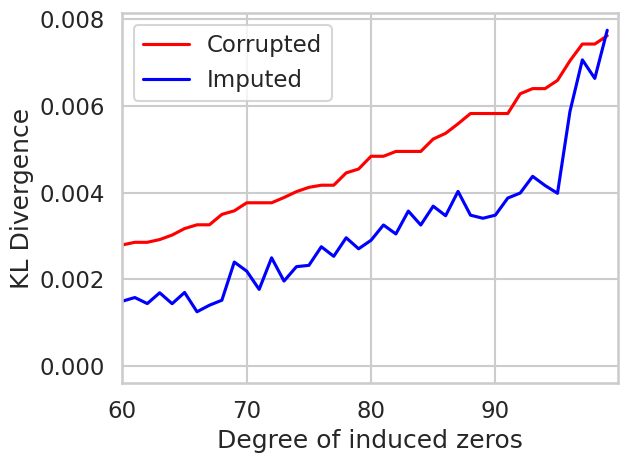

In [61]:
plt.plot (np.linspace(0,99,100),y1, label = 'Corrupted', color = 'red')
plt.plot (np.linspace(0,99,100),y2, label = 'Imputed', color = 'blue')

plt.ylabel('KL Divergence')
plt.xlabel('Degree of induced zeros')
plt.legend()
# Rango específico del eje x (por ejemplo, de 20 a 50)
plt.xlim(60, 99.9)

plt.show()

In [62]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# calculate the kl divergence
def kl_divergence(p, q):
    return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))

# calculate the js divergence
def js_divergence(p, q):
  m = 0.5 * (p + q)
  return (0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m))

def histo(matrix_dropouted,bins):
  flatten_data_dropouted = matrix_dropouted.to_numpy().flatten()
  hst_dropouted = sns.histplot(data=flatten_data_dropouted, bins=bins, stat = "probability");
  return({h.get_height() for h in hst_dropouted.patches})

r=[]
I = []
for i in range(100):

  i=i/100
#  print(i)
  matrix_dropouted = matrix_dropout(table_shotgun_ok, por_drop = i,seed=3)
#  print(calcular_tasa_ceros(matrix_dropouted))
  flatten_data_dropouted = matrix_dropouted.to_numpy().flatten()
  hst_dropouted = sns.histplot(data=flatten_data_dropouted, bins=bins, stat = "probability");
  Heigth_dropouted = [h.get_height() for h in hst_dropouted.patches]
  #  width = [h.get_x() for h in hst_dropouted.patches]
  #deltw = [h.get_width() for h in hst.patches]
  plt.clf()

  r.append(kl_divergence(np.array(Heigth_dropouted), np.array(Heigth_ok)))

  ## Imputation
  umap_op = umap.UMAP(n_components=10, verbose=True,metric='euclidean',n_epochs=500,min_dist=0.1, n_neighbors=30,random_state=7,target_weight=0.5)
  data_umap_vis_super = umap_op.fit_transform(matrix_dropouted,labels['SampleType'].replace( {'Healthy': 0, 'UC':1}))
  # regresar t a 2, unicamente utilizar 1 si con los datos artificiales
  imputed_ALL, markov_matrix =mbPHENIX(matrix_dropouted, data_umap_vis_super, t=2,decay=600,metric='euclidean',knn=3,return_type='both')
  imputed_ALL =rescale_data(matrix_dropouted, imputed_ALL, rescale_percent=99.99)
  imputed_ALL = put_zeros(imputed_ALL, matrix_dropouted, markov_matrix, k=20, threshold=2, keep_outliers=True)



  flatten_data_imputed = imputed_ALL.to_numpy().flatten()
  hst_imputed = sns.histplot(data=flatten_data_imputed, bins=bins, stat = "probability");
  Heigth_imputed = [h.get_height() for h in hst_imputed.patches]
  plt.clf()

  I.append(kl_divergence(np.array(Heigth_imputed), np.array(Heigth_ok)))
z1 = r
z2= I

UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:40:36 2023 Construct fuzzy simplicial set
Sun Jul  2 10:40:36 2023 Finding Nearest Neighbors
Sun Jul  2 10:40:36 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:40:36 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:40:37 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:40:37 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:41:08 2023 Construct fuzzy simplicial set
Sun Jul  2 10:41:08 2023 Finding Nearest Neighbors
Sun Jul  2 10:41:08 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:41:08 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:41:10 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:41:10 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:41:39 2023 Construct fuzzy simplicial set
Sun Jul  2 10:41:39 2023 Finding Nearest Neighbors
Sun Jul  2 10:41:39 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:41:39 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:41:40 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:41:40 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:42:09 2023 Construct fuzzy simplicial set
Sun Jul  2 10:42:09 2023 Finding Nearest Neighbors
Sun Jul  2 10:42:09 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:42:09 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:42:11 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:42:11 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:42:40 2023 Construct fuzzy simplicial set
Sun Jul  2 10:42:40 2023 Finding Nearest Neighbors
Sun Jul  2 10:42:40 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:42:40 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:42:41 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:42:41 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:43:11 2023 Construct fuzzy simplicial set
Sun Jul  2 10:43:11 2023 Finding Nearest Neighbors
Sun Jul  2 10:43:11 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:43:11 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:43:12 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:43:12 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:43:41 2023 Construct fuzzy simplicial set
Sun Jul  2 10:43:41 2023 Finding Nearest Neighbors
Sun Jul  2 10:43:41 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:43:41 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:43:43 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:43:43 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:44:11 2023 Construct fuzzy simplicial set
Sun Jul  2 10:44:11 2023 Finding Nearest Neighbors
Sun Jul  2 10:44:11 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:44:11 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:44:13 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:44:13 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:44:43 2023 Construct fuzzy simplicial set
Sun Jul  2 10:44:43 2023 Finding Nearest Neighbors
Sun Jul  2 10:44:43 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:44:43 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:44:44 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:44:44 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:45:13 2023 Construct fuzzy simplicial set
Sun Jul  2 10:45:13 2023 Finding Nearest Neighbors
Sun Jul  2 10:45:13 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:45:13 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:45:14 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:45:14 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:45:44 2023 Construct fuzzy simplicial set
Sun Jul  2 10:45:44 2023 Finding Nearest Neighbors
Sun Jul  2 10:45:44 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:45:44 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:45:46 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:45:46 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:46:15 2023 Construct fuzzy simplicial set
Sun Jul  2 10:46:15 2023 Finding Nearest Neighbors
Sun Jul  2 10:46:15 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:46:15 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:46:16 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:46:16 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:46:46 2023 Construct fuzzy simplicial set
Sun Jul  2 10:46:46 2023 Finding Nearest Neighbors
Sun Jul  2 10:46:46 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:46:46 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:46:47 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:46:47 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:47:17 2023 Construct fuzzy simplicial set
Sun Jul  2 10:47:17 2023 Finding Nearest Neighbors
Sun Jul  2 10:47:17 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:47:17 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:47:18 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:47:18 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:47:47 2023 Construct fuzzy simplicial set
Sun Jul  2 10:47:47 2023 Finding Nearest Neighbors
Sun Jul  2 10:47:47 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:47:47 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:47:49 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:47:49 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:48:19 2023 Construct fuzzy simplicial set
Sun Jul  2 10:48:19 2023 Finding Nearest Neighbors
Sun Jul  2 10:48:19 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:48:19 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:48:20 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:48:20 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:48:50 2023 Construct fuzzy simplicial set
Sun Jul  2 10:48:50 2023 Finding Nearest Neighbors
Sun Jul  2 10:48:50 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:48:50 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:48:51 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:48:51 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:49:22 2023 Construct fuzzy simplicial set
Sun Jul  2 10:49:22 2023 Finding Nearest Neighbors
Sun Jul  2 10:49:22 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:49:22 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:49:23 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:49:23 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:49:52 2023 Construct fuzzy simplicial set
Sun Jul  2 10:49:52 2023 Finding Nearest Neighbors
Sun Jul  2 10:49:52 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:49:52 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:49:53 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:49:53 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:50:24 2023 Construct fuzzy simplicial set
Sun Jul  2 10:50:24 2023 Finding Nearest Neighbors
Sun Jul  2 10:50:24 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:50:25 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:50:26 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:50:26 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:50:56 2023 Construct fuzzy simplicial set
Sun Jul  2 10:50:56 2023 Finding Nearest Neighbors
Sun Jul  2 10:50:56 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:50:56 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:50:57 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:50:57 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:51:27 2023 Construct fuzzy simplicial set
Sun Jul  2 10:51:27 2023 Finding Nearest Neighbors
Sun Jul  2 10:51:27 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:51:27 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:51:29 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:51:29 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:52:00 2023 Construct fuzzy simplicial set
Sun Jul  2 10:52:00 2023 Finding Nearest Neighbors
Sun Jul  2 10:52:00 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:52:00 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:52:01 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:52:01 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:52:32 2023 Construct fuzzy simplicial set
Sun Jul  2 10:52:32 2023 Finding Nearest Neighbors
Sun Jul  2 10:52:32 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:52:32 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:52:33 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:52:33 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:53:03 2023 Construct fuzzy simplicial set
Sun Jul  2 10:53:03 2023 Finding Nearest Neighbors
Sun Jul  2 10:53:03 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:53:03 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:53:04 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:53:04 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:53:34 2023 Construct fuzzy simplicial set
Sun Jul  2 10:53:34 2023 Finding Nearest Neighbors
Sun Jul  2 10:53:34 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:53:34 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:53:36 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:53:36 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:54:06 2023 Construct fuzzy simplicial set
Sun Jul  2 10:54:06 2023 Finding Nearest Neighbors
Sun Jul  2 10:54:06 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:54:06 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:54:08 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:54:08 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:54:39 2023 Construct fuzzy simplicial set
Sun Jul  2 10:54:39 2023 Finding Nearest Neighbors
Sun Jul  2 10:54:39 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:54:39 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:54:40 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:54:40 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:55:11 2023 Construct fuzzy simplicial set
Sun Jul  2 10:55:11 2023 Finding Nearest Neighbors
Sun Jul  2 10:55:11 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:55:11 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:55:12 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:55:12 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:55:44 2023 Construct fuzzy simplicial set
Sun Jul  2 10:55:44 2023 Finding Nearest Neighbors
Sun Jul  2 10:55:44 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:55:44 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:55:45 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:55:45 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:56:16 2023 Construct fuzzy simplicial set
Sun Jul  2 10:56:16 2023 Finding Nearest Neighbors
Sun Jul  2 10:56:16 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:56:16 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:56:17 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:56:17 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:56:48 2023 Construct fuzzy simplicial set
Sun Jul  2 10:56:48 2023 Finding Nearest Neighbors
Sun Jul  2 10:56:48 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:56:48 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:56:49 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:56:49 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:57:20 2023 Construct fuzzy simplicial set
Sun Jul  2 10:57:20 2023 Finding Nearest Neighbors
Sun Jul  2 10:57:20 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:57:20 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:57:22 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:57:22 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:57:53 2023 Construct fuzzy simplicial set
Sun Jul  2 10:57:53 2023 Finding Nearest Neighbors
Sun Jul  2 10:57:53 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:57:53 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:57:54 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:57:54 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:58:24 2023 Construct fuzzy simplicial set
Sun Jul  2 10:58:24 2023 Finding Nearest Neighbors
Sun Jul  2 10:58:24 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:58:24 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:58:26 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:58:26 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:58:57 2023 Construct fuzzy simplicial set
Sun Jul  2 10:58:57 2023 Finding Nearest Neighbors
Sun Jul  2 10:58:57 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:58:57 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:58:58 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:58:58 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 10:59:30 2023 Construct fuzzy simplicial set
Sun Jul  2 10:59:30 2023 Finding Nearest Neighbors
Sun Jul  2 10:59:30 2023 Finished Nearest Neighbor Search
Sun Jul  2 10:59:30 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 10:59:31 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 10:59:31 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:00:03 2023 Construct fuzzy simplicial set
Sun Jul  2 11:00:03 2023 Finding Nearest Neighbors
Sun Jul  2 11:00:03 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:00:03 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:00:04 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:00:04 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:00:37 2023 Construct fuzzy simplicial set
Sun Jul  2 11:00:37 2023 Finding Nearest Neighbors
Sun Jul  2 11:00:37 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:00:37 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:00:39 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:00:39 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:01:09 2023 Construct fuzzy simplicial set
Sun Jul  2 11:01:09 2023 Finding Nearest Neighbors
Sun Jul  2 11:01:09 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:01:09 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:01:11 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:01:11 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:01:41 2023 Construct fuzzy simplicial set
Sun Jul  2 11:01:41 2023 Finding Nearest Neighbors
Sun Jul  2 11:01:41 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:01:41 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:01:42 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:01:42 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:02:14 2023 Construct fuzzy simplicial set
Sun Jul  2 11:02:14 2023 Finding Nearest Neighbors
Sun Jul  2 11:02:14 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:02:14 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:02:15 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:02:15 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:02:46 2023 Construct fuzzy simplicial set
Sun Jul  2 11:02:46 2023 Finding Nearest Neighbors
Sun Jul  2 11:02:46 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:02:46 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:02:47 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:02:47 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:03:18 2023 Construct fuzzy simplicial set
Sun Jul  2 11:03:18 2023 Finding Nearest Neighbors
Sun Jul  2 11:03:18 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:03:18 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:03:20 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:03:20 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:03:50 2023 Construct fuzzy simplicial set
Sun Jul  2 11:03:50 2023 Finding Nearest Neighbors
Sun Jul  2 11:03:50 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:03:50 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:03:52 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:03:52 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:04:23 2023 Construct fuzzy simplicial set
Sun Jul  2 11:04:23 2023 Finding Nearest Neighbors
Sun Jul  2 11:04:23 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:04:23 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:04:24 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:04:24 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:04:55 2023 Construct fuzzy simplicial set
Sun Jul  2 11:04:55 2023 Finding Nearest Neighbors
Sun Jul  2 11:04:55 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:04:55 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:04:56 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:04:56 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:05:27 2023 Construct fuzzy simplicial set
Sun Jul  2 11:05:27 2023 Finding Nearest Neighbors
Sun Jul  2 11:05:27 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:05:27 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:05:28 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:05:28 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:05:59 2023 Construct fuzzy simplicial set
Sun Jul  2 11:05:59 2023 Finding Nearest Neighbors
Sun Jul  2 11:05:59 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:05:59 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:06:00 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:06:00 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:06:32 2023 Construct fuzzy simplicial set
Sun Jul  2 11:06:32 2023 Finding Nearest Neighbors
Sun Jul  2 11:06:32 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:06:32 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:06:33 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:06:33 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:07:04 2023 Construct fuzzy simplicial set
Sun Jul  2 11:07:04 2023 Finding Nearest Neighbors
Sun Jul  2 11:07:04 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:07:04 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:07:05 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:07:05 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:07:38 2023 Construct fuzzy simplicial set
Sun Jul  2 11:07:38 2023 Finding Nearest Neighbors
Sun Jul  2 11:07:38 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:07:38 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:07:39 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:07:39 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:08:10 2023 Construct fuzzy simplicial set
Sun Jul  2 11:08:10 2023 Finding Nearest Neighbors
Sun Jul  2 11:08:10 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:08:10 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:08:11 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:08:11 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:08:43 2023 Construct fuzzy simplicial set
Sun Jul  2 11:08:43 2023 Finding Nearest Neighbors
Sun Jul  2 11:08:43 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:08:43 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:08:44 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:08:44 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:09:15 2023 Construct fuzzy simplicial set
Sun Jul  2 11:09:15 2023 Finding Nearest Neighbors
Sun Jul  2 11:09:15 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:09:15 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:09:16 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:09:16 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:09:47 2023 Construct fuzzy simplicial set
Sun Jul  2 11:09:47 2023 Finding Nearest Neighbors
Sun Jul  2 11:09:47 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:09:47 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:09:48 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:09:48 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:10:22 2023 Construct fuzzy simplicial set
Sun Jul  2 11:10:22 2023 Finding Nearest Neighbors
Sun Jul  2 11:10:22 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:10:22 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:10:23 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:10:23 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:11:14 2023 Construct fuzzy simplicial set
Sun Jul  2 11:11:14 2023 Finding Nearest Neighbors
Sun Jul  2 11:11:14 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:11:14 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:11:16 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:11:16 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:11:49 2023 Construct fuzzy simplicial set
Sun Jul  2 11:11:49 2023 Finding Nearest Neighbors
Sun Jul  2 11:11:49 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:11:49 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:11:50 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:11:50 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:12:20 2023 Construct fuzzy simplicial set
Sun Jul  2 11:12:20 2023 Finding Nearest Neighbors
Sun Jul  2 11:12:20 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:12:21 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:12:22 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:12:22 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:12:55 2023 Construct fuzzy simplicial set
Sun Jul  2 11:12:55 2023 Finding Nearest Neighbors
Sun Jul  2 11:12:55 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:12:55 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:12:56 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:12:56 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:13:27 2023 Construct fuzzy simplicial set
Sun Jul  2 11:13:27 2023 Finding Nearest Neighbors
Sun Jul  2 11:13:27 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:13:27 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:13:28 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:13:28 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:14:02 2023 Construct fuzzy simplicial set
Sun Jul  2 11:14:02 2023 Finding Nearest Neighbors
Sun Jul  2 11:14:02 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:14:02 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:14:03 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:14:03 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:14:36 2023 Construct fuzzy simplicial set
Sun Jul  2 11:14:36 2023 Finding Nearest Neighbors
Sun Jul  2 11:14:36 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:14:36 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:14:38 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:14:38 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:15:10 2023 Construct fuzzy simplicial set
Sun Jul  2 11:15:10 2023 Finding Nearest Neighbors
Sun Jul  2 11:15:10 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:15:10 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:15:12 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:15:12 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:15:44 2023 Construct fuzzy simplicial set
Sun Jul  2 11:15:44 2023 Finding Nearest Neighbors
Sun Jul  2 11:15:44 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:15:44 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:15:46 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:15:46 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:16:19 2023 Construct fuzzy simplicial set
Sun Jul  2 11:16:19 2023 Finding Nearest Neighbors
Sun Jul  2 11:16:19 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:16:19 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:16:20 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:16:20 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:16:54 2023 Construct fuzzy simplicial set
Sun Jul  2 11:16:54 2023 Finding Nearest Neighbors
Sun Jul  2 11:16:54 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:16:54 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:16:55 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:16:55 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:17:26 2023 Construct fuzzy simplicial set
Sun Jul  2 11:17:26 2023 Finding Nearest Neighbors
Sun Jul  2 11:17:26 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:17:26 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:17:28 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:17:28 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:18:01 2023 Construct fuzzy simplicial set
Sun Jul  2 11:18:01 2023 Finding Nearest Neighbors
Sun Jul  2 11:18:01 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:18:01 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:18:03 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:18:03 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:18:36 2023 Construct fuzzy simplicial set
Sun Jul  2 11:18:36 2023 Finding Nearest Neighbors
Sun Jul  2 11:18:36 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:18:36 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:18:37 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:18:37 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:19:09 2023 Construct fuzzy simplicial set
Sun Jul  2 11:19:09 2023 Finding Nearest Neighbors
Sun Jul  2 11:19:09 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:19:09 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:19:10 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:19:10 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:19:43 2023 Construct fuzzy simplicial set
Sun Jul  2 11:19:43 2023 Finding Nearest Neighbors
Sun Jul  2 11:19:43 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:19:43 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:19:44 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:19:44 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:20:17 2023 Construct fuzzy simplicial set
Sun Jul  2 11:20:17 2023 Finding Nearest Neighbors
Sun Jul  2 11:20:17 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:20:17 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:20:18 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:20:19 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-i

UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:20:51 2023 Construct fuzzy simplicial set
Sun Jul  2 11:20:51 2023 Finding Nearest Neighbors
Sun Jul  2 11:20:51 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:20:51 2023 Construct embedding
UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:20:51 2023 Construct fuzzy simplicial set
Sun Jul  2 11:20:51 2023 Finding Nearest Neighbors
Sun Jul  2 11:20:51 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:20:51 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:20:52 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:20:52 2023
Sun Jul  2 11:20:52 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:20:52 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:21:23 2023 Construct fuzzy simplicial set
Sun Jul  2 11:21:23 2023 Finding Nearest Neighbors
Sun Jul  2 11:21:23 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:21:23 2023 Construct embedding
UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:21:23 2023 Construct fuzzy simplicial set
Sun Jul  2 11:21:23 2023 Finding Nearest Neighbors
Sun Jul  2 11:21:23 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:21:23 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log

Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:21:25 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:21:25 2023
Sun Jul  2 11:21:25 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:21:25 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:21:57 2023 Construct fuzzy simplicial set
Sun Jul  2 11:21:57 2023 Finding Nearest Neighbors
Sun Jul  2 11:21:57 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:21:57 2023 Construct embedding
UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:21:57 2023 Construct fuzzy simplicial set
Sun Jul  2 11:21:57 2023 Finding Nearest Neighbors
Sun Jul  2 11:21:57 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:21:57 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log

Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:21:58 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:21:58 2023
Sun Jul  2 11:21:58 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:21:58 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:22:28 2023 Construct fuzzy simplicial set
Sun Jul  2 11:22:28 2023 Finding Nearest Neighbors
Sun Jul  2 11:22:28 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:22:28 2023 Construct embedding
UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:22:28 2023 Construct fuzzy simplicial set
Sun Jul  2 11:22:28 2023 Finding Nearest Neighbors
Sun Jul  2 11:22:28 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:22:28 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log

Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:22:29 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:22:29 2023
Sun Jul  2 11:22:29 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:22:29 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:22:59 2023 Construct fuzzy simplicial set
Sun Jul  2 11:22:59 2023 Finding Nearest Neighbors
Sun Jul  2 11:22:59 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:22:59 2023 Construct embedding
UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:22:59 2023 Construct fuzzy simplicial set
Sun Jul  2 11:22:59 2023 Finding Nearest Neighbors
Sun Jul  2 11:22:59 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:22:59 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log

Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:23:01 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:23:01 2023
Sun Jul  2 11:23:01 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:23:01 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:23:32 2023 Construct fuzzy simplicial set
Sun Jul  2 11:23:32 2023 Finding Nearest Neighbors
Sun Jul  2 11:23:32 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:23:32 2023 Construct embedding
UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:23:32 2023 Construct fuzzy simplicial set
Sun Jul  2 11:23:32 2023 Finding Nearest Neighbors
Sun Jul  2 11:23:32 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:23:32 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log

Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:23:33 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:23:33 2023
Sun Jul  2 11:23:33 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:23:33 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:24:04 2023 Construct fuzzy simplicial set
Sun Jul  2 11:24:04 2023 Finding Nearest Neighbors
Sun Jul  2 11:24:04 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:24:04 2023 Construct embedding
UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:24:04 2023 Construct fuzzy simplicial set
Sun Jul  2 11:24:04 2023 Finding Nearest Neighbors
Sun Jul  2 11:24:04 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:24:04 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log

Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:24:05 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:24:05 2023
Sun Jul  2 11:24:05 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:24:05 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:24:37 2023 Construct fuzzy simplicial set
Sun Jul  2 11:24:37 2023 Finding Nearest Neighbors
Sun Jul  2 11:24:37 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:24:37 2023 Construct embedding
UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:24:37 2023 Construct fuzzy simplicial set
Sun Jul  2 11:24:37 2023 Finding Nearest Neighbors
Sun Jul  2 11:24:37 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:24:37 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log

Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:24:39 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:24:39 2023
Sun Jul  2 11:24:39 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:24:39 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5

UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:25:11 2023 Construct fuzzy simplicial set
Sun Jul  2 11:25:11 2023 Finding Nearest Neighbors
Sun Jul  2 11:25:11 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:25:11 2023 Construct embedding
UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:25:11 2023 Construct fuzzy simplicial set
Sun Jul  2 11:25:11 2023 Finding Nearest Neighbors
Sun Jul  2 11:25:11 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:25:11 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))


Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:25:12 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:25:12 2023
Sun Jul  2 11:25:12 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:25:12 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:25:44 2023 Construct fuzzy simplicial set
Sun Jul  2 11:25:44 2023 Finding Nearest Neighbors
Sun Jul  2 11:25:44 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:25:44 2023 Construct embedding
UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:25:44 2023 Construct fuzzy simplicial set
Sun Jul  2 11:25:44 2023 Finding Nearest Neighbors
Sun Jul  2 11:25:44 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:25:44 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log

Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:25:46 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:25:46 2023
Sun Jul  2 11:25:46 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:25:46 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:26:19 2023 Construct fuzzy simplicial set
Sun Jul  2 11:26:19 2023 Finding Nearest Neighbors
Sun Jul  2 11:26:19 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:26:19 2023 Construct embedding
UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:26:19 2023 Construct fuzzy simplicial set
Sun Jul  2 11:26:19 2023 Finding Nearest Neighbors
Sun Jul  2 11:26:19 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:26:19 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log

Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:26:20 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:26:20 2023
Sun Jul  2 11:26:20 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:26:20 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:26:53 2023 Construct fuzzy simplicial set
Sun Jul  2 11:26:53 2023 Finding Nearest Neighbors
Sun Jul  2 11:26:53 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:26:53 2023 Construct embedding
UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:26:53 2023 Construct fuzzy simplicial set
Sun Jul  2 11:26:53 2023 Finding Nearest Neighbors
Sun Jul  2 11:26:53 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:26:53 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log

Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:26:54 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:26:54 2023
Sun Jul  2 11:26:54 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:26:54 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:27:27 2023 Construct fuzzy simplicial set
Sun Jul  2 11:27:27 2023 Finding Nearest Neighbors
Sun Jul  2 11:27:27 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:27:27 2023 Construct embedding
UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:27:27 2023 Construct fuzzy simplicial set
Sun Jul  2 11:27:27 2023 Finding Nearest Neighbors
Sun Jul  2 11:27:27 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:27:27 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log

Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:27:28 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:27:28 2023
Sun Jul  2 11:27:28 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:27:28 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:28:00 2023 Construct fuzzy simplicial set
Sun Jul  2 11:28:00 2023 Finding Nearest Neighbors
Sun Jul  2 11:28:00 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:28:00 2023 Construct embedding
UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:28:00 2023 Construct fuzzy simplicial set
Sun Jul  2 11:28:00 2023 Finding Nearest Neighbors
Sun Jul  2 11:28:00 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:28:00 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log

Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:28:01 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:28:01 2023
Sun Jul  2 11:28:01 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:28:01 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:28:34 2023 Construct fuzzy simplicial set
Sun Jul  2 11:28:34 2023 Finding Nearest Neighbors
Sun Jul  2 11:28:34 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:28:34 2023 Construct embedding
UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:28:34 2023 Construct fuzzy simplicial set
Sun Jul  2 11:28:34 2023 Finding Nearest Neighbors
Sun Jul  2 11:28:34 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:28:34 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log

Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:28:36 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:28:36 2023
Sun Jul  2 11:28:36 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:28:36 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:29:08 2023 Construct fuzzy simplicial set
Sun Jul  2 11:29:08 2023 Finding Nearest Neighbors
Sun Jul  2 11:29:08 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:29:08 2023 Construct embedding
UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:29:08 2023 Construct fuzzy simplicial set
Sun Jul  2 11:29:08 2023 Finding Nearest Neighbors
Sun Jul  2 11:29:08 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:29:08 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log

Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:29:09 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:29:09 2023
Sun Jul  2 11:29:09 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:29:09 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:29:42 2023 Construct fuzzy simplicial set
Sun Jul  2 11:29:42 2023 Finding Nearest Neighbors
Sun Jul  2 11:29:42 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:29:42 2023 Construct embedding
UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:29:42 2023 Construct fuzzy simplicial set
Sun Jul  2 11:29:42 2023 Finding Nearest Neighbors
Sun Jul  2 11:29:42 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:29:42 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log

Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:29:43 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:29:43 2023
Sun Jul  2 11:29:43 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:29:43 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:30:17 2023 Construct fuzzy simplicial set
Sun Jul  2 11:30:17 2023 Finding Nearest Neighbors
Sun Jul  2 11:30:17 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:30:17 2023 Construct embedding
UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:30:17 2023 Construct fuzzy simplicial set
Sun Jul  2 11:30:17 2023 Finding Nearest Neighbors
Sun Jul  2 11:30:17 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:30:17 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log

Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:30:19 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:30:19 2023
Sun Jul  2 11:30:19 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:30:19 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:30:52 2023 Construct fuzzy simplicial set
Sun Jul  2 11:30:52 2023 Finding Nearest Neighbors
Sun Jul  2 11:30:52 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:30:52 2023 Construct embedding
UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:30:52 2023 Construct fuzzy simplicial set
Sun Jul  2 11:30:52 2023 Finding Nearest Neighbors
Sun Jul  2 11:30:52 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:30:52 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log

Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:30:53 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:30:53 2023
Sun Jul  2 11:30:53 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:30:53 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5

UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:31:27 2023 Construct fuzzy simplicial set
Sun Jul  2 11:31:27 2023 Finding Nearest Neighbors
Sun Jul  2 11:31:27 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:31:27 2023 Construct embedding
UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:31:27 2023 Construct fuzzy simplicial set
Sun Jul  2 11:31:27 2023 Finding Nearest Neighbors
Sun Jul  2 11:31:27 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:31:27 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:31:28 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:31:28 2023
Sun Jul  2 11:31:28 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:31:28 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5

UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:32:01 2023 Construct fuzzy simplicial set
Sun Jul  2 11:32:01 2023 Finding Nearest Neighbors
Sun Jul  2 11:32:01 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:32:01 2023 Construct embedding
UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:32:01 2023 Construct fuzzy simplicial set
Sun Jul  2 11:32:01 2023 Finding Nearest Neighbors
Sun Jul  2 11:32:01 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:32:01 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:32:03 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:32:03 2023
Sun Jul  2 11:32:03 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:32:03 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:32:34 2023 Construct fuzzy simplicial set
Sun Jul  2 11:32:34 2023 Finding Nearest Neighbors
Sun Jul  2 11:32:34 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:32:34 2023 Construct embedding
UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:32:34 2023 Construct fuzzy simplicial set
Sun Jul  2 11:32:34 2023 Finding Nearest Neighbors
Sun Jul  2 11:32:34 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:32:34 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log

Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:32:36 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:32:36 2023
Sun Jul  2 11:32:36 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:32:36 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:33:08 2023 Construct fuzzy simplicial set
Sun Jul  2 11:33:08 2023 Finding Nearest Neighbors
Sun Jul  2 11:33:08 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:33:08 2023 Construct embedding
UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:33:08 2023 Construct fuzzy simplicial set
Sun Jul  2 11:33:08 2023 Finding Nearest Neighbors
Sun Jul  2 11:33:08 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:33:08 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log

Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:33:10 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:33:10 2023
Sun Jul  2 11:33:10 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:33:10 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:33:43 2023 Construct fuzzy simplicial set
Sun Jul  2 11:33:43 2023 Finding Nearest Neighbors
Sun Jul  2 11:33:43 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:33:43 2023 Construct embedding
UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:33:43 2023 Construct fuzzy simplicial set
Sun Jul  2 11:33:43 2023 Finding Nearest Neighbors
Sun Jul  2 11:33:43 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:33:43 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log

Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:33:45 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:33:45 2023
Sun Jul  2 11:33:45 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:33:45 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:34:19 2023 Construct fuzzy simplicial set
Sun Jul  2 11:34:19 2023 Finding Nearest Neighbors
Sun Jul  2 11:34:19 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:34:19 2023 Construct embedding
UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:34:19 2023 Construct fuzzy simplicial set
Sun Jul  2 11:34:19 2023 Finding Nearest Neighbors
Sun Jul  2 11:34:19 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:34:19 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log

Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:34:20 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:34:20 2023
Sun Jul  2 11:34:20 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:34:20 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)


UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:34:54 2023 Construct fuzzy simplicial set
Sun Jul  2 11:34:54 2023 Finding Nearest Neighbors
Sun Jul  2 11:34:54 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:34:54 2023 Construct embedding
UMAP(n_components=10, n_epochs=500, n_neighbors=30, random_state=7, verbose=True)
Sun Jul  2 11:34:54 2023 Construct fuzzy simplicial set
Sun Jul  2 11:34:54 2023 Finding Nearest Neighbors
Sun Jul  2 11:34:54 2023 Finished Nearest Neighbor Search
Sun Jul  2 11:34:54 2023 Construct embedding


<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log

Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            0/500 [00:00]

Sun Jul  2 11:34:55 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:34:55 2023
Sun Jul  2 11:34:55 2023 Finished embedding
calculating distances
 afinity matrix done
imputation
done
done Sun Jul  2 11:34:55 2023


<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-39-ee8b78ddfa93>:61: RuntimeWarning: overflow encountered in power
  E = np.exp(-1 * (pdx_scale ** decay))
<ipython-input-39-ee8b78ddfa93>:141: RuntimeWarning: invalid value encountered in true_divide
  max_ratio = np.divide(M99_original, M99_imputed)
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0.0, p * np.log(p / q), 0))
<ipython-input-62-f0ed661ef58e>:5

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

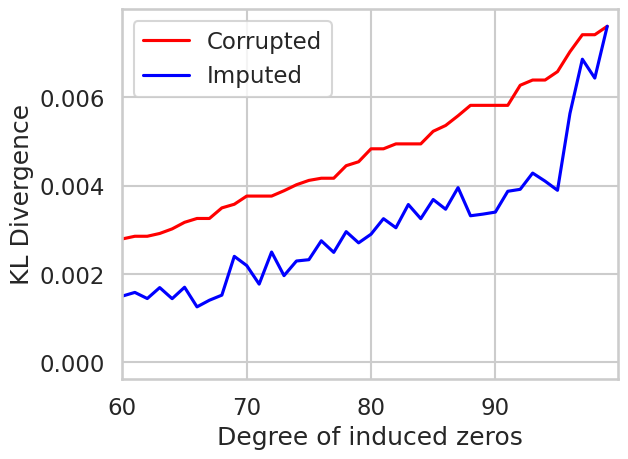

In [63]:
plt.plot (np.linspace(0,99,100),z1, label = 'Corrupted', color = 'red')
plt.plot (np.linspace(0,99,100),z2, label = 'Imputed', color = 'blue')

plt.ylabel('KL Divergence')
plt.xlabel('Degree of induced zeros')
plt.legend()
# Rango específico del eje x (por ejemplo, de 20 a 50)
plt.xlim(60, 99.9)

plt.show()